# Ames Housing Analysis - Modelling and Predictions

Note: This is a continuation of the Ames Housing Anaylsis. Please refer to the Data Cleaning and EDA for elaboration on the problem statement, cleaning, encoding, and rationales.

Caveat: This code takes a reallllllllly long time to run. Also, no random seed was set so if you re-run the kernel your results will differ each time. This is to allow me to generate multiple iterations of the model from scratch and compare the results.

## 1. Library Imports

In [1]:
#Imports:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV, BayesianRidge, ElasticNetCV, ElasticNet
from sklearn import neighbors
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, RobustScaler, Imputer, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, IterativeImputer, MissingIndicator
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, KFold
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline, make_union
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE

%matplotlib inline

## 2. Train Test Split, Folds, and Standardization

In [2]:
X_full = pd.read_csv (r'.\datasets\train_cleaned.csv')
Kag_full = pd.read_csv (r'.\datasets\test_cleaned.csv')

In [3]:
X = X_full.drop("saleprice", axis = 1)
y = X_full["saleprice"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, shuffle = True)

In [4]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1434, 149) (615, 149) (1434,) (615,)


I have decided to use sklearn's robustscaler to scale the data, due to the number of possible outliers.
I will initiate both scalers and create dataframes for both though, in case I want to test different scalers.

In [5]:
rs = RobustScaler(quantile_range=(10,90))
X_train_rs = rs.fit_transform(X_train)
X_test_rs = rs.transform(X_test)
kag_rs = rs.fit_transform(Kag_full)

ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

In [6]:
X_train_rs.shape

(1434, 149)

## 3. Model Benchmarks

### 3.1 Mean

Using the mean of our dependent variable should yield an r2 score of 0.
As long as we achieve an r2 of greater than 0, we are doing better than simply predicting using the mean.

### 3.2 Linear Regression

In [7]:
kf = KFold(n_splits = 5, shuffle = True)

In [8]:
def model_something(X, y, est, find_alpha = False, scaler = ss):
    #lets me choose what scaler I want to use in the function
    scale_list = {"rs": RobustScaler(quantile_range = (10, 90)), "ss":StandardScaler()}

    X_scaled = scale_list[scaler].fit_transform(X)
    model_estimator = est
    model = model_estimator.fit(X_scaled, y)
    r2_score = cross_val_score(model_estimator, X_scaled, y, cv = kf, scoring="r2").mean()
    mse_score = -cross_val_score(model_estimator, X_scaled, y, cv = kf, scoring = "neg_mean_squared_error").mean()    
    print(r2_score, mse_score)

In [9]:
model_something(X_train, y_train, est = LinearRegression(), scaler = "rs")

0.9007055759019096 599682940.4044452


A simple MLR using all features yields us an R2 of 0.89 and MSE of over 600 million. This is our score to beat!

## 4. Feature Selection

I will be using three methods to select my features:

### 4.1 Feature Selection by Correlation (Filter Method)

In [10]:
#Generates a one column "heatmap" that highlights the top n correlations for a particular feature.
#Used as a quick feature selection heuristic
def quick_heat(my_df, feature, n=10):
    plt.style.use('ggplot')
    plt.figure(figsize=(15, n*0.6))
    data = pd.DataFrame(my_df.corr()[feature].abs().sort_values(ascending=False)).drop([feature,"saleprice"], axis = 0).head(n)
    sns.heatmap(data, cmap="YlGnBu", annot=True).set_title("Correlations to {} (Absolute Value)".format(feature))
    corr_list = data.index
    return list(corr_list)

In [11]:
def slow_heat(my_df, features, title = "No title set"):
    plt.style.use('ggplot')
    # Establish size of figure.
    plt.figure(figsize=(20,20))  
    corr = my_df[features].corr()

    # Set up mask to be "True" in the upper triangle.
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    # Plot our correlation heatmap, while masking the upper triangle to be white.
    with sns.axes_style("white"):
        sns.heatmap(corr, mask=mask, vmax=.3, square=True, annot=True, cmap="coolwarm").set_title(title, fontsize=20)


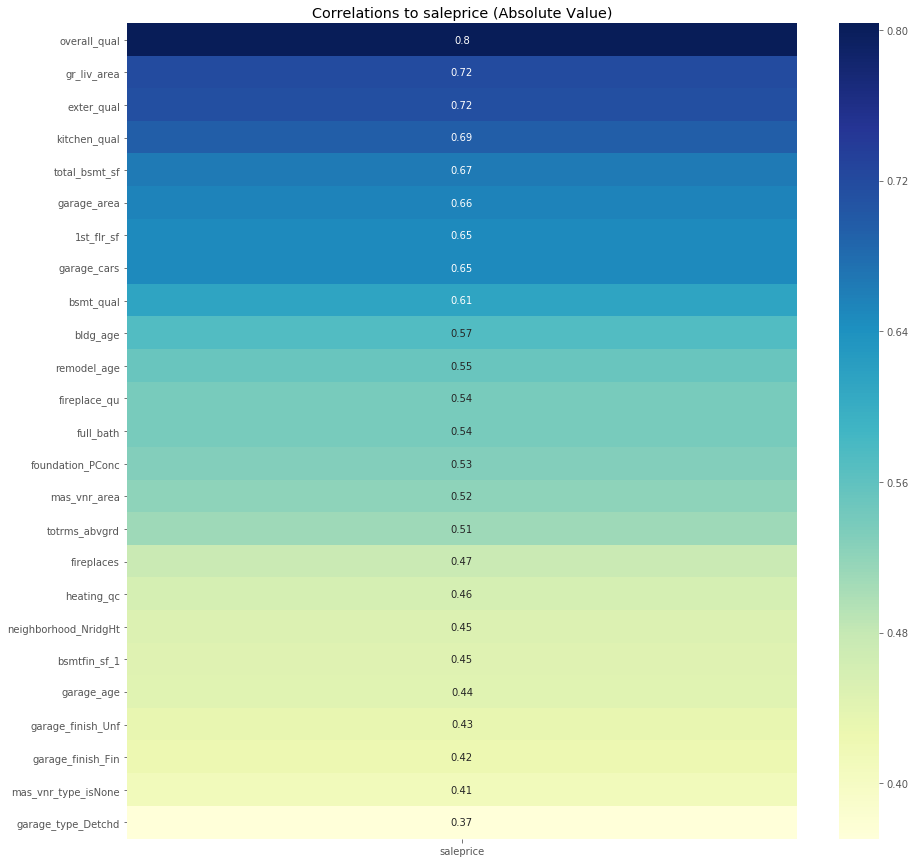

In [12]:
rs = RobustScaler()
corr_list = quick_heat(pd.DataFrame(data = rs.fit_transform(X_full), columns = X_full.columns), "saleprice", n= 25)

The "heatmap" above captures our top 25 highest correlated variables.

In [13]:
#List of top 25 highest correlated variables to test in models
corr_list

['overall_qual',
 'gr_liv_area',
 'exter_qual',
 'kitchen_qual',
 'total_bsmt_sf',
 'garage_area',
 '1st_flr_sf',
 'garage_cars',
 'bsmt_qual',
 'bldg_age',
 'remodel_age',
 'fireplace_qu',
 'full_bath',
 'foundation_PConc',
 'mas_vnr_area',
 'totrms_abvgrd',
 'fireplaces',
 'heating_qc',
 'neighborhood_NridgHt',
 'bsmtfin_sf_1',
 'garage_age',
 'garage_finish_Unf',
 'garage_finish_Fin',
 'mas_vnr_type_isNone',
 'garage_type_Detchd']

### 4.2 Feature Selection by Lasso (Embedded Method)

In [14]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(X_train_rs, y_train)

lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso.fit(X_train_rs, y_train)

cv_score = cross_val_score(lasso, X_train_rs, y_train, cv=kf).mean()

print(cv_score)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.8858518605340031


In [77]:
#Generate a dataframe with our coefficients, intercepts, and feature names.
lasso_df = pd.DataFrame({"Coeff": lasso.coef_, "Intercept": lasso.intercept_}, index = X_train.columns)

lasso_list = lasso_df.abs().sort_values(by = "Coeff", ascending = False).head(25).index.tolist()
lasso_df = lasso_df.abs().sort_values(by = "Coeff", ascending = False).head(25)

Text(0, 0.5, 'Coefficient')

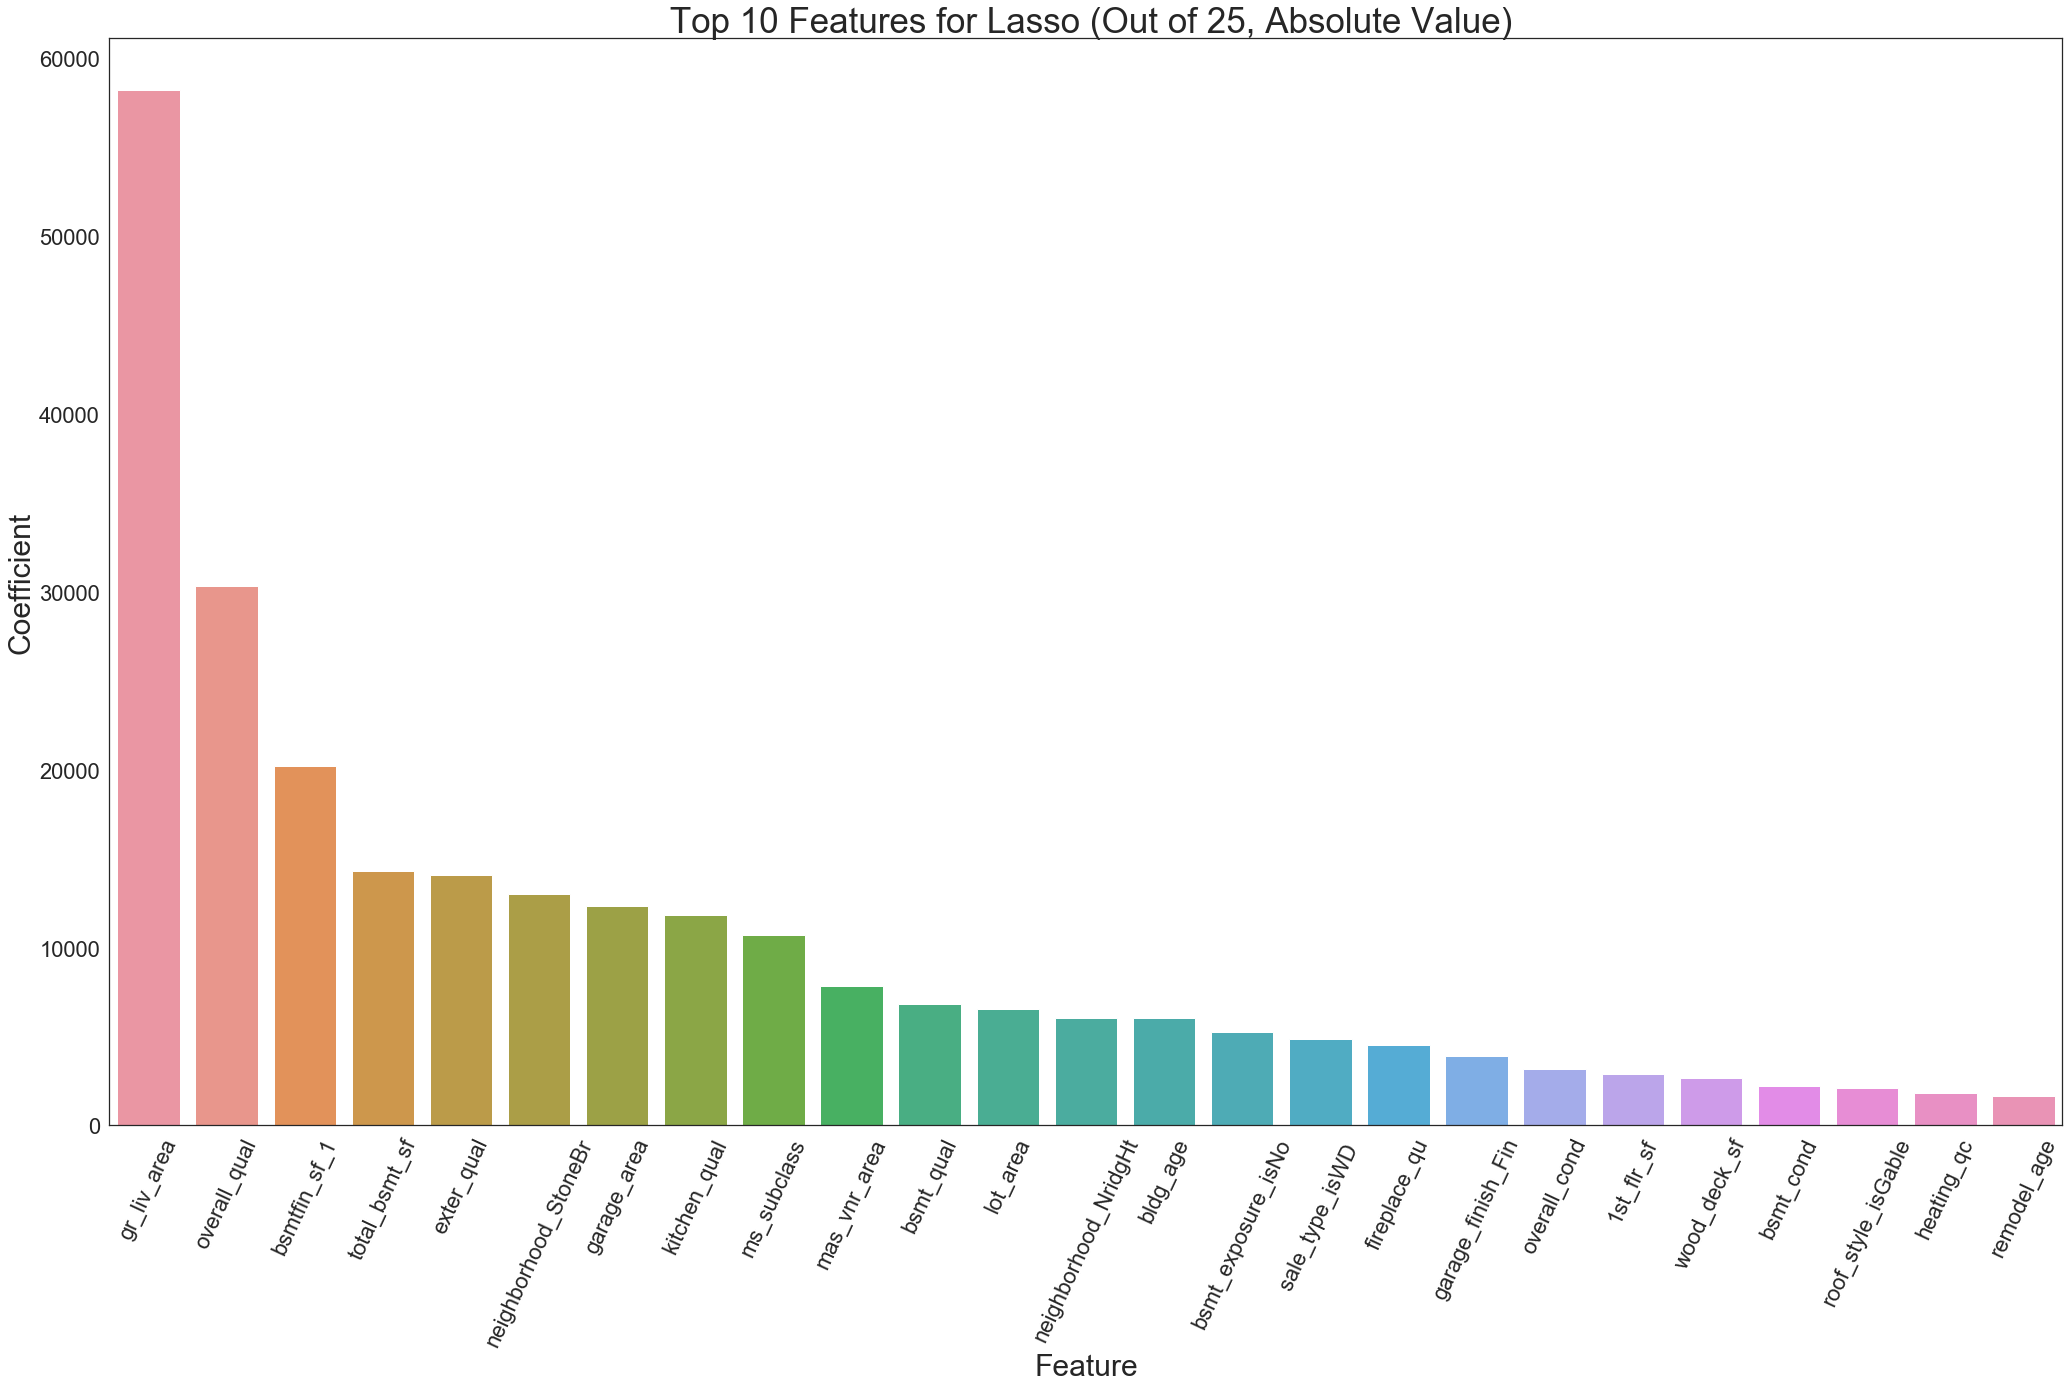

In [78]:
#Plot feature importance
plt.figure(figsize = (35,20))
sns.set(font_scale = 2, style="white")
ax = sns.barplot(x = lasso_df.index, y = lasso_df["Coeff"], data = lasso_df.head(10))
plt.setp(ax.get_xticklabels(), rotation=65)
ax.set_title(" Top 10 Features for Lasso (Out of 25, Absolute Value)", fontsize = 35)
ax.set_xlabel("Feature", fontsize = 30)
ax.set_ylabel("Coefficient", fontsize = 30)

### 4.3 Feature Selection by RFE (Wrapper Method)

#### 4.3.1 RFE with Linear Regression

In [79]:
lr = LinearRegression()

#Choose 25 features
rfe = RFE(lr, n_features_to_select=25)
rfe.fit(X_train_rs, y_train)

cv_score = cross_val_score(rfe, X_train_rs, y_train, cv = kf).mean()
temp = pd.Series(rfe.support_,index = X_train.columns)

#returns a list to be used in later analysis and modelling. 
rfe_list = temp[temp==True].index.tolist()
print("R2 mean: {}".format(cv_score))
print(rfe_list)

R2 mean: 0.8788763174400648
['overall_qual', 'exter_qual', 'bsmtfin_sf_1', 'total_bsmt_sf', 'gr_liv_area', 'bedroom_abvgr', 'garage_area', 'bldg_age', 'bldg_type_is1Fam', 'heating_isGasA', 'neighborhood_Crawfor', 'neighborhood_GrnHill', 'neighborhood_NPkVill', 'neighborhood_NoRidge', 'neighborhood_NridgHt', 'neighborhood_StoneBr', 'exterior_1st_BrkComm', 'exterior_1st_BrkFace', 'exterior_1st_ImStucc', 'exterior_2nd_Brk Cmn', 'foundation_Slab', 'foundation_Wood', 'garage_type_2Types', 'garage_finish_RFn', 'garage_finish_Unf']


Text(0, 0.5, 'Coefficient')

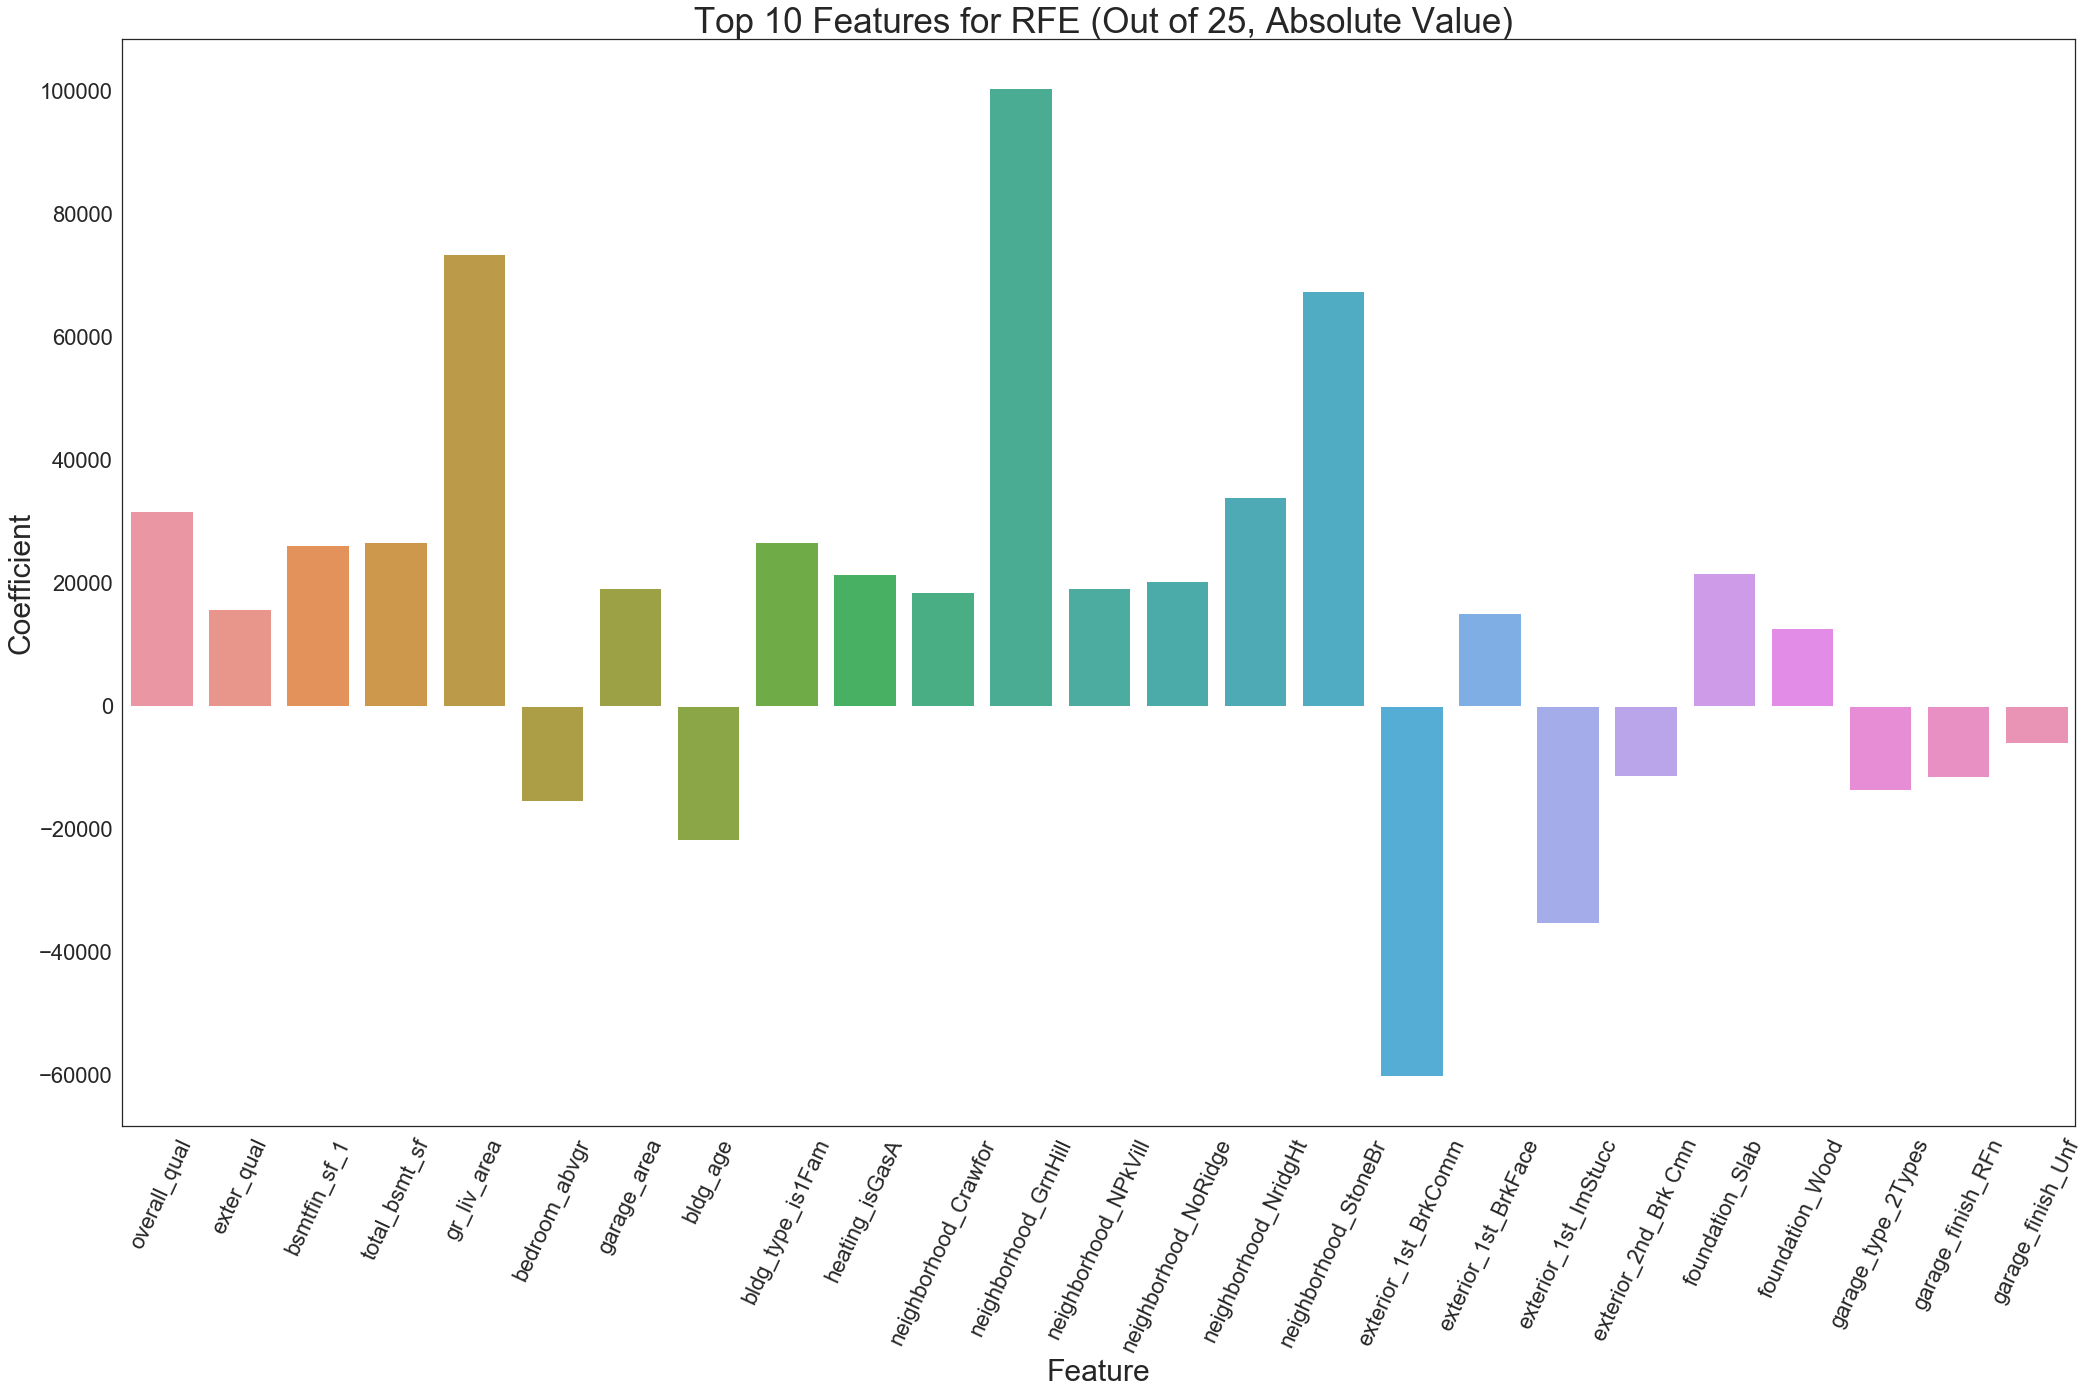

In [80]:
#Plot coefficients from LR RFE
lr = LinearRegression()
lr.fit(rs.fit_transform(X_train[rfe_list]), y_train)

plt.figure(figsize = (35,20))
sns.set(font_scale = 2, style="white")
ax = sns.barplot(x = rfe_list, y = lr.coef_)
plt.setp(ax.get_xticklabels(), rotation=65)
ax.set_title(" Top 10 Features for RFE (Out of 25, Absolute Value)", fontsize = 35)
ax.set_xlabel("Feature", fontsize = 30)
ax.set_ylabel("Coefficient", fontsize = 30)


#### 4.3.1 RFE with Ridge

In [81]:
ridge_alphas = np.logspace(0, 10, 500)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=kf)
optimal_ridge.fit(X_train_rs, y_train)

ridge = Ridge(alpha=optimal_ridge.alpha_)

#Choose 25 features
rfe = RFE(ridge, n_features_to_select=25)
rfe.fit(X_train_rs, y_train)

cv_score = cross_val_score(rfe, X_train_rs, y_train, cv = kf).mean()
temp = pd.Series(rfe.support_,index = X_train.columns)
rfe_list = temp[temp==True].index.tolist()
print("R2 mean: {}".format(cv_score))
print(rfe_list)

R2 mean: 0.8879890903740787
['overall_qual', 'exter_qual', 'bsmtfin_sf_1', 'total_bsmt_sf', '1st_flr_sf', '2nd_flr_sf', 'gr_liv_area', 'bedroom_abvgr', 'garage_area', 'bldg_age', 'remodel_age', 'bldg_type_is1Fam', 'roof_matl_isCompShg', 'heating_isGasA', 'functional_isTyp', 'neighborhood_Crawfor', 'neighborhood_GrnHill', 'neighborhood_NoRidge', 'neighborhood_NridgHt', 'neighborhood_SawyerW', 'neighborhood_StoneBr', 'exterior_1st_BrkComm', 'exterior_1st_BrkFace', 'exterior_1st_CemntBd', 'foundation_Slab']


In [82]:
#Performing a ridge again with the list of features selected by RFE
ridge_alphas = np.logspace(0, 10, 500)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=kf)
optimal_ridge.fit(rs.fit_transform(X_train[rfe_list]), y_train)

RidgeCV(alphas=array([1.00000000e+00, 1.04722519e+00, 1.09668060e+00, 1.14847155e+00,
       1.20270833e+00, 1.25950646e+00, 1.31898690e+00, 1.38127630e+00,
       1.44650734e+00, 1.51481892e+00, 1.58635653e+00, 1.66127252e+00,
       1.73972643e+00, 1.82188534e+00, 1.90792422e+00, 1.99802631e+00,
       2.09238348e+00, 2.19119669e+00, 2.29467637e+00, 2.40304289e+00,
       2.51652705e+00, 2.63537052e+0...
       5.00493910e+09, 5.24129830e+09, 5.48881961e+09, 5.74803016e+09,
       6.01948197e+09, 6.30375315e+09, 6.60144909e+09, 6.91320378e+09,
       7.23968114e+09, 7.58157646e+09, 7.93961785e+09, 8.31456781e+09,
       8.70722485e+09, 9.11842520e+09, 9.54904456e+09, 1.00000000e+10]),
        cv=KFold(n_splits=5, random_state=None, shuffle=True),
        fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
        store_cv_values=False)

Text(0, 0.5, 'Coefficient')

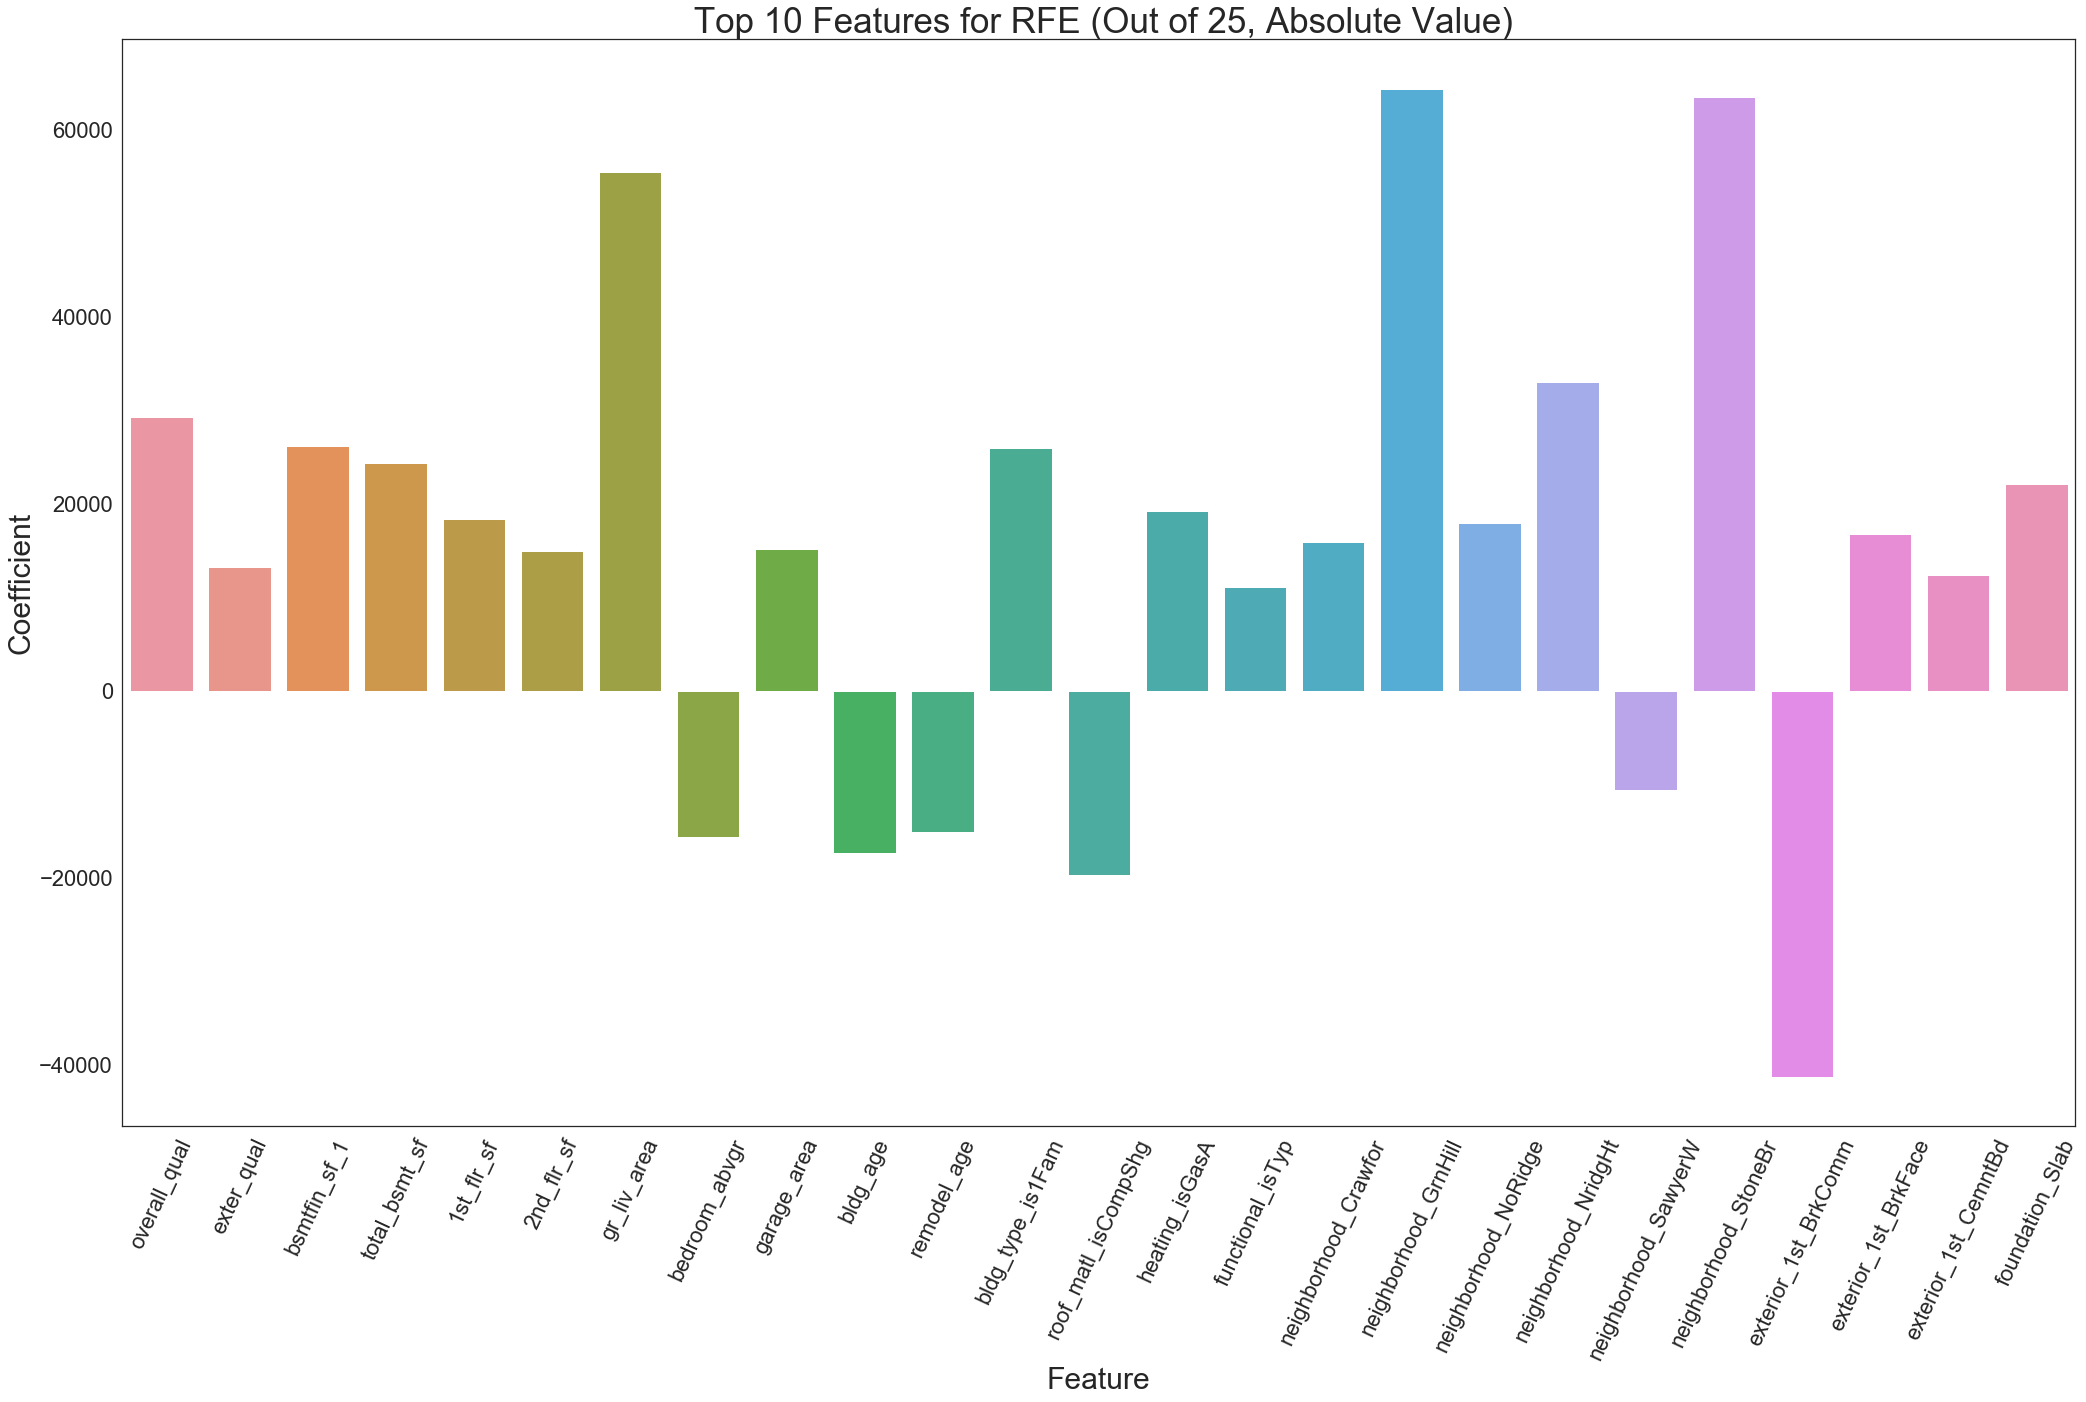

In [83]:
plt.figure(figsize = (35,20))
sns.set(font_scale = 2, style="white")
ax = sns.barplot(x = rfe_list, y = optimal_ridge.coef_)
plt.setp(ax.get_xticklabels(), rotation=65)
ax.set_title(" Top 10 Features for RFE (Out of 25, Absolute Value)", fontsize = 35)
ax.set_xlabel("Feature", fontsize = 30)
ax.set_ylabel("Coefficient", fontsize = 30)


### 4.4 Comparing Selected Features

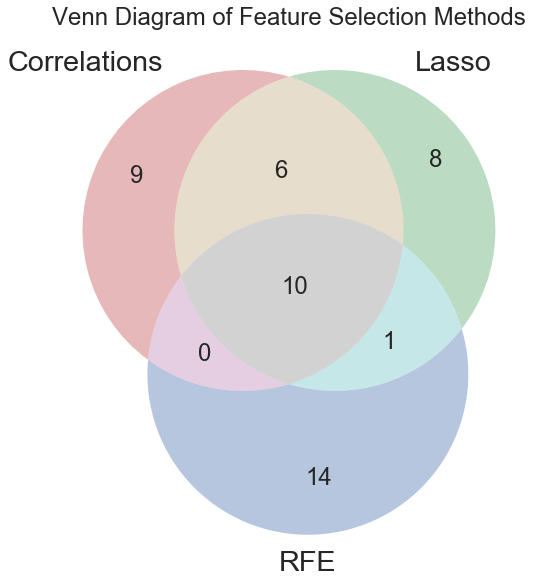

In [85]:
# This needs the matplotlib venn library to be installed and imported
# This venn diagram compares the features between all 3 feature lists, and shows the overlap.
from matplotlib_venn import venn3

plt.figure(figsize = (15, 10))
set1 = set(corr_list)
set2 = set(lasso_list)
set3 = set(rfe_list)

plt.title("Venn Diagram of Feature Selection Methods")
venn3([set1, set2, set3], ('Correlations', 'Lasso', 'RFE'))

<img src='.\datasets\Venn_Features.png'>
There are only 10 shared features among all 3 feature selection methods!
If we want to keep our model simple, perhaps these 10 features are the best ones to select, especially if we use polynomial features, which will inflate our processing time and increase our dimensionality.

We have also generated four lists: correlation (filtering method), rfe (wrapper method), lasso (embedded method), and a list comprising of the intersection of the three. I will be running models on all four lists to further examine what features are ideal.

In [23]:
# List of 10 shared features
combined_list = list(set(corr_list).intersection(rfe_list, lasso_list))
combined_list

['gr_liv_area',
 'bsmtfin_sf_1',
 'neighborhood_NridgHt',
 'remodel_age',
 '1st_flr_sf',
 'overall_qual',
 'bldg_age',
 'garage_area',
 'exter_qual',
 'total_bsmt_sf']

### 4.5 Multicolinearity

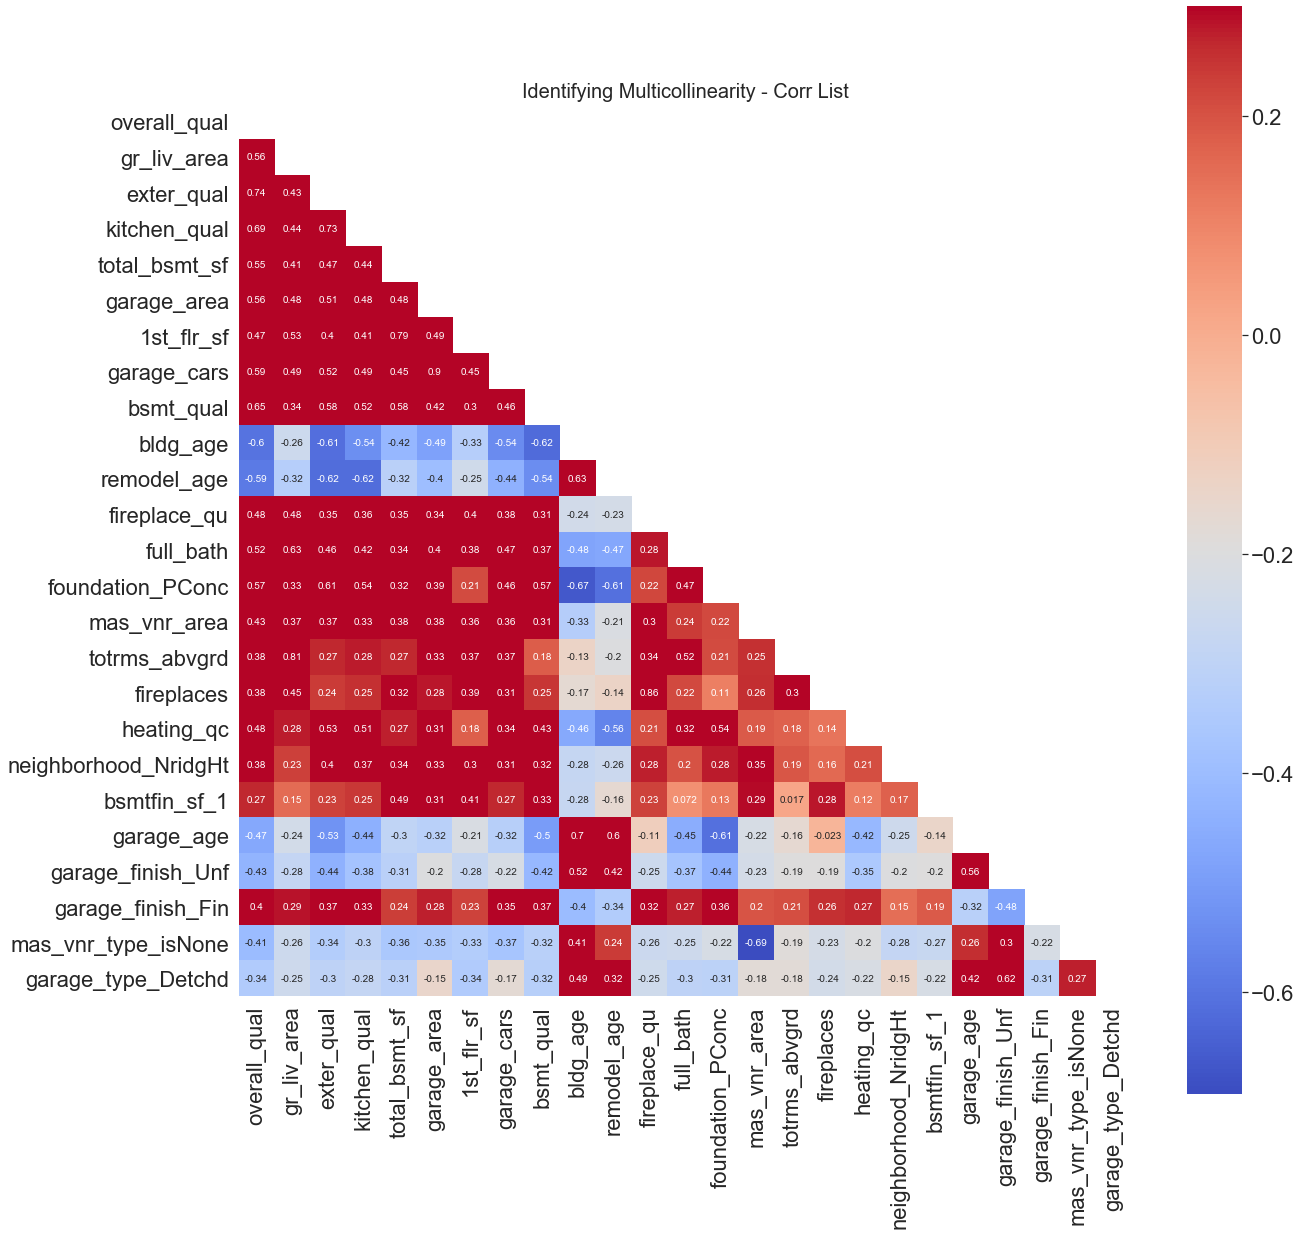

In [24]:
slow_heat(X_full, corr_list, "Identifying Multicollinearity - Corr List")

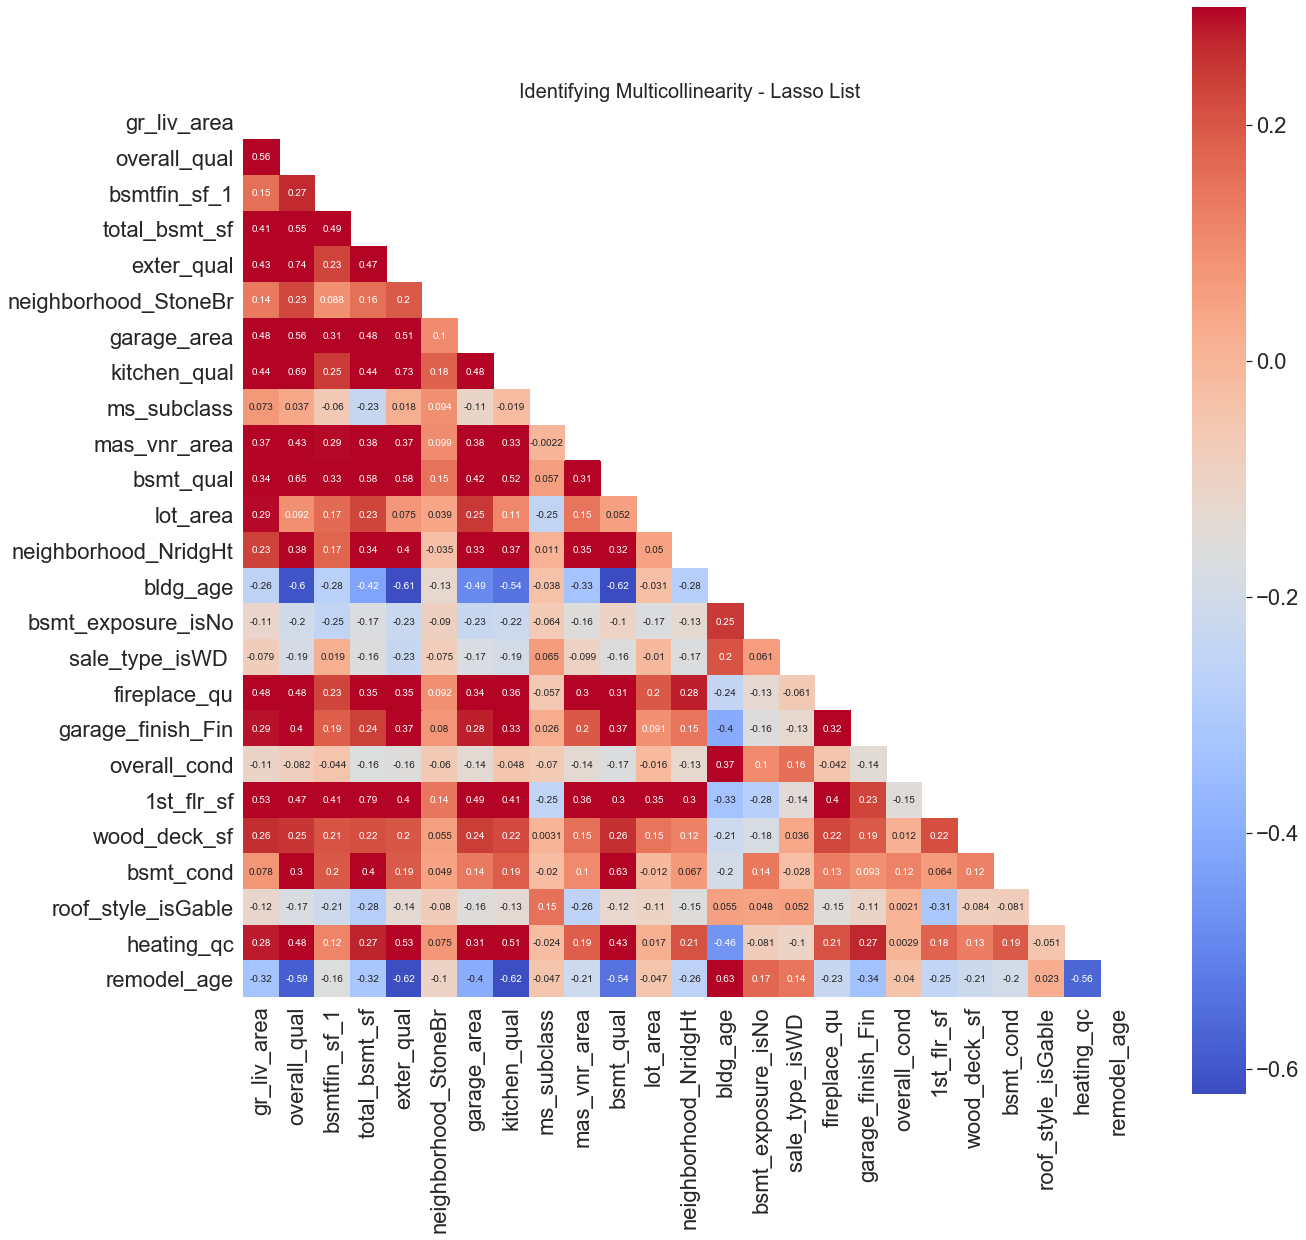

In [25]:
slow_heat(X_full, lasso_list, "Identifying Multicollinearity - Lasso List")

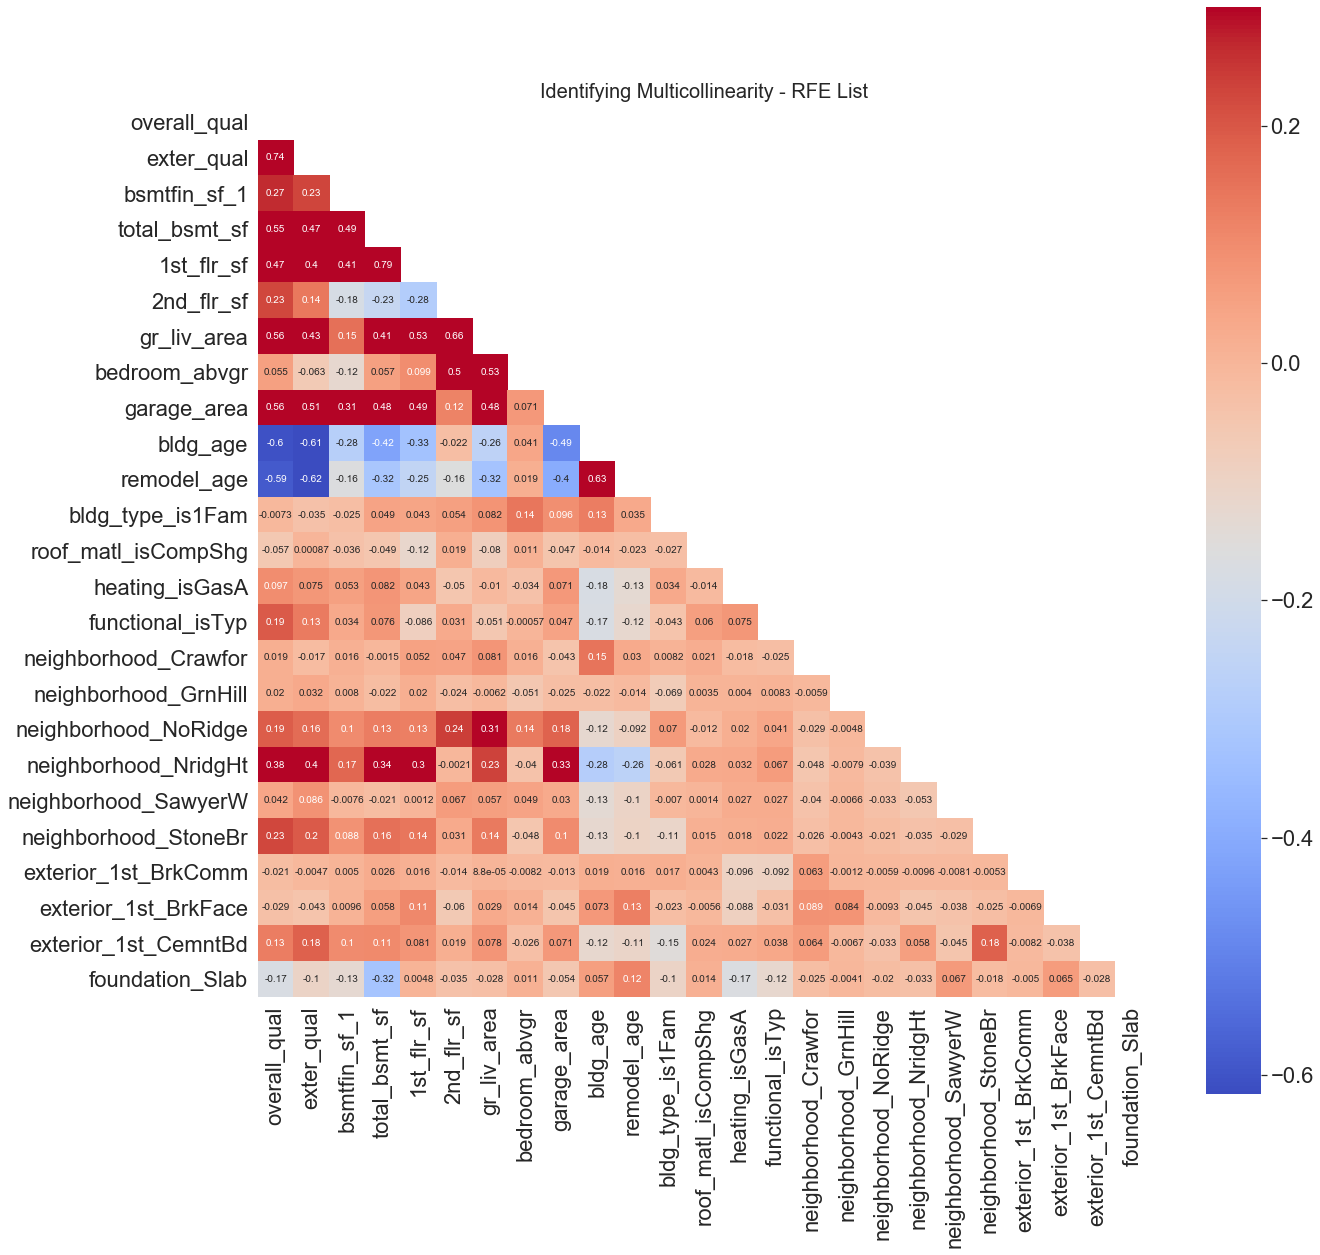

In [26]:
slow_heat(X_full, rfe_list, "Identifying Multicollinearity - RFE List")

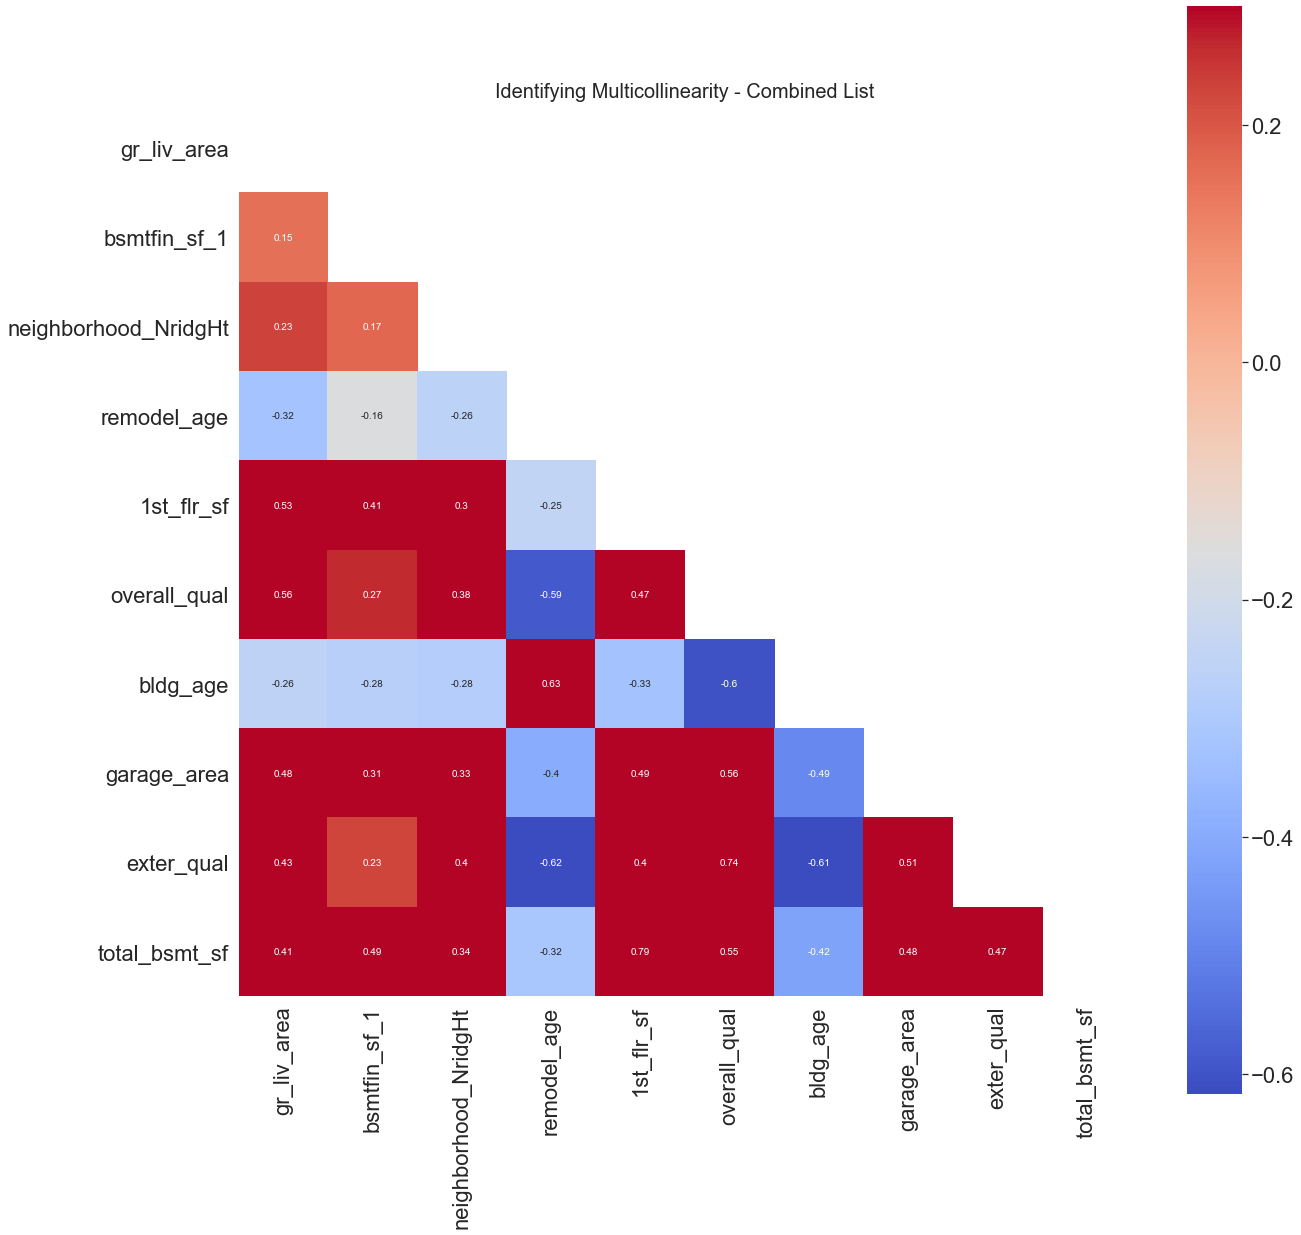

In [27]:
slow_heat(X_full, combined_list, "Identifying Multicollinearity - Combined List")

Wow, that's a lot of multicollinearity - building age is negatively correlated with a lot of the quality features (e.g overall_qual, exter_qual), which makes sense. Likewise, the quality features correlated highly with themselves (e.g. exter_qual and overall_qual).

To deal with this, I will use polynomial functions to attempt to lessen the effects of multicollinearity.

## 5. Modelling and Tuning

###  5.1 Ridge

In [28]:
#Running this is painful, it will take awhile
#Also, this is bad code
def ridge_plots(X, y, Xtest, ytest, features, title):
    
    sns.set(font_scale = 1)
    sns.set_style('white')

    #only takes in featurers that are present in the kaggle test set
    #this is a workaround for not having run "get dummies" on both test and train sets, so the shapes are different
    data = pd.DataFrame(data = X, columns = X_train.columns)[[n for n in Kag_full.columns if n in features]]
    Xtest = pd.DataFrame(data = Xtest, columns = X_test.columns)[[n for n in Kag_full.columns if n in features]]
    kag = pd.DataFrame(data = kag_rs, columns = Kag_full.columns)[[n for n in Kag_full.columns if n in features]]
    
    #find optimal alpha
    ridge_alphas = np.logspace(0, 10, 500)    
    optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=kf)
    optimal_ridge.fit(data, y)

    ridge = Ridge(alpha=optimal_ridge.alpha_)
    ridge.fit(data, y)
    
    #score the model
    r2 = np.round(cross_val_score(ridge, data, y, cv=kf, scoring = "r2").mean(), decimals = 2)
    mse = np.round(-cross_val_score(ridge, data, y, cv=kf, scoring = "neg_mean_squared_error").mean(), decimals = 2)
    
    #predict for test set, and predict for kaggle set if we want to export to kaggle
    predictions = ridge.predict(Xtest)
    predictions2 = ridge.predict(kag)
    plt.figure(figsize=(15,10))
    ax1 = sns.regplot(predictions, ytest, marker="x")
    ax1.set_title("Y vs Yhat for Ridge Regression - {}".format(title))
    ax1.set_xlabel("Yhat", fontsize = 16) 
    ax1.set_xlabel("Y", fontsize = 16) 
    ax1.text(0.15, 0.83, "Mean R2: {}".format(r2), ha="left", va="top", transform=ax1.transAxes, fontsize=12)
    ax1.text(0.15, 0.8, "Mean MSE: {}".format(mse), ha="left", va="top", transform=ax1.transAxes, fontsize=12)
    return predictions2, r2, mse

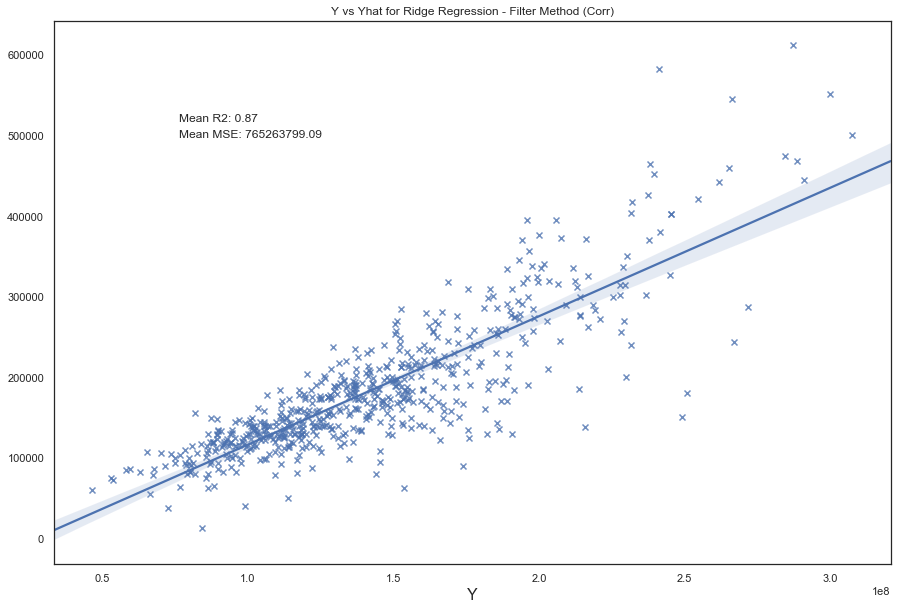

In [29]:
preds = ridge_plots(X_train_rs, y_train, X_test, y_test, corr_list, "Filter Method (Corr)")

In [30]:
filter_ridge_r2 = preds[1]
filter_ridge_mse = preds[2]

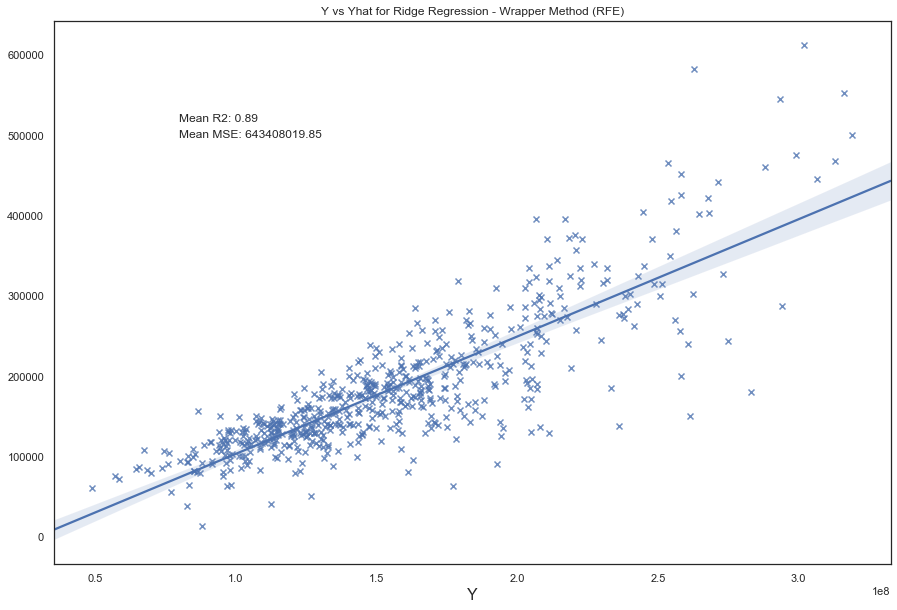

In [31]:
preds = ridge_plots(X_train_rs, y_train, X_test, y_test, rfe_list, "Wrapper Method (RFE)")

In [32]:
wrapper_ridge_r2 = preds[1]
wrapper_ridge_mse = preds[2]

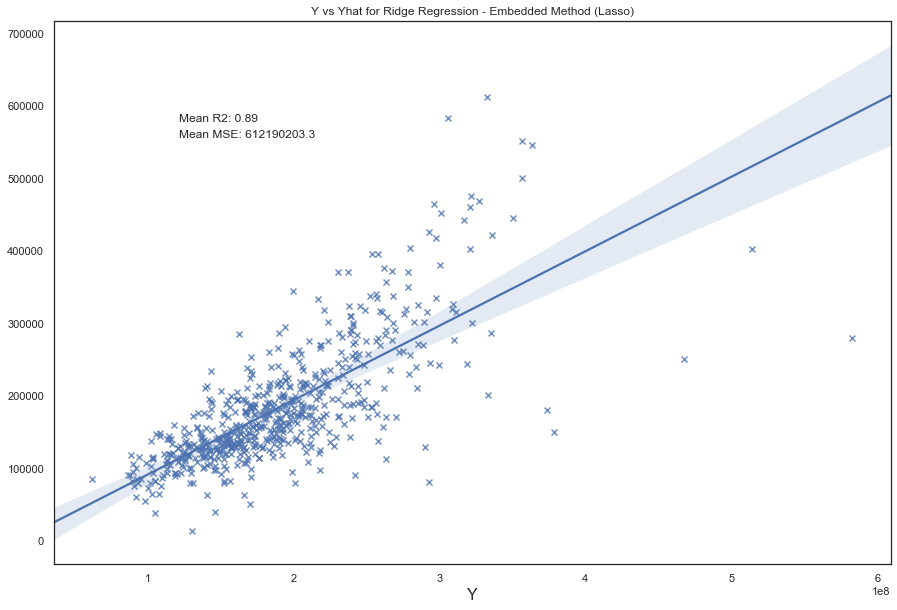

In [33]:
preds = ridge_plots(X_train_rs, y_train, X_test, y_test, lasso_list, "Embedded Method (Lasso)")

In [34]:
embedded_ridge_r2 = preds[1]
embedded_ridge_mse = preds[2]

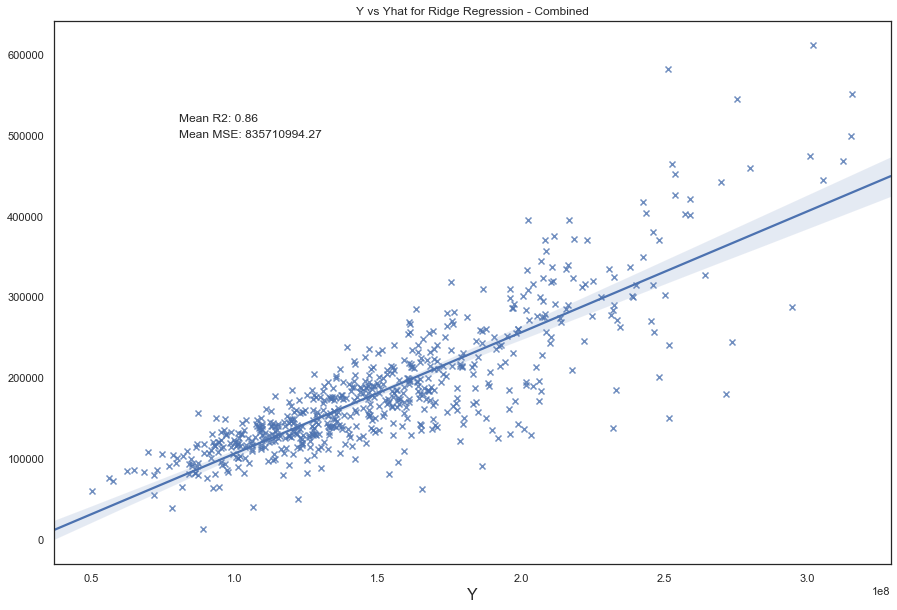

In [35]:
preds = ridge_plots(X_train_rs, y_train, X_test, y_test, combined_list, "Combined")

In [36]:
combined_ridge_r2 = preds[1]
combined_ridge_mse = preds[2]

### 5.2 Lasso

In [37]:
#Running this is painful, it will take awhile
#Also, this is bad code
def lasso_plots(X, y, Xtest, ytest, features, title):
    sns.set(font_scale = 1)
    sns.set_style('white')
    
    #only takes in featurers that are present in the kaggle test set
    data = pd.DataFrame(data = X, columns = X_train.columns)[[n for n in Kag_full.columns if n in features]]
    Xtest = pd.DataFrame(data = Xtest, columns = X_test.columns)[[n for n in Kag_full.columns if n in features]]
    kag = pd.DataFrame(data = kag_rs, columns = Kag_full.columns)[[n for n in Kag_full.columns if n in features]]
    
    #find optimal alpha
    optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
    optimal_lasso.fit(data, y)

    lasso = Lasso(alpha=optimal_lasso.alpha_)
    lasso.fit(data, y)

    #score the model
    r2 = np.round(cross_val_score(lasso, data, y, cv=kf, scoring = "r2").mean(), decimals = 2)
    mse = np.round(-cross_val_score(lasso, data, y, cv=kf, scoring = "neg_mean_squared_error").mean(), decimals = 2)
    
    #predict for test set, and predict for kaggle set if we want to export to kaggle
    predictions = lasso.predict(Xtest)
    predictions2 = lasso.predict(kag)
    plt.figure(figsize=(15,10))
    ax1 = sns.regplot(predictions, ytest, marker="x")
    ax1.set_title("Y vs Yhat for Lasso - {}".format(title))
    ax1.set_xlabel("Yhat") 
    ax1.set_xlabel("Y") 
    ax1.text(0.15, 0.83, "Mean R2: {}".format(r2), ha="left", va="top", transform=ax1.transAxes, fontsize=12)
    ax1.text(0.15, 0.8, "Mean MSE: {}".format(mse), ha="left", va="top", transform=ax1.transAxes, fontsize=12)
    return predictions2, r2, mse

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

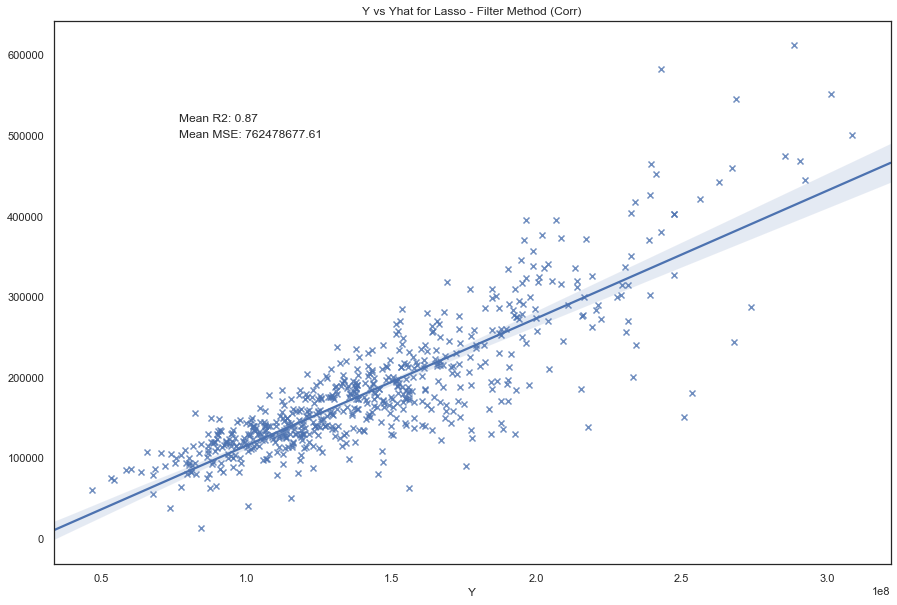

In [38]:
preds = lasso_plots(X_train_rs, y_train, X_test, y_test, corr_list, "Filter Method (Corr)")

In [39]:
filter_lasso_r2 = preds[1]
filter_lasso_mse = preds[2]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

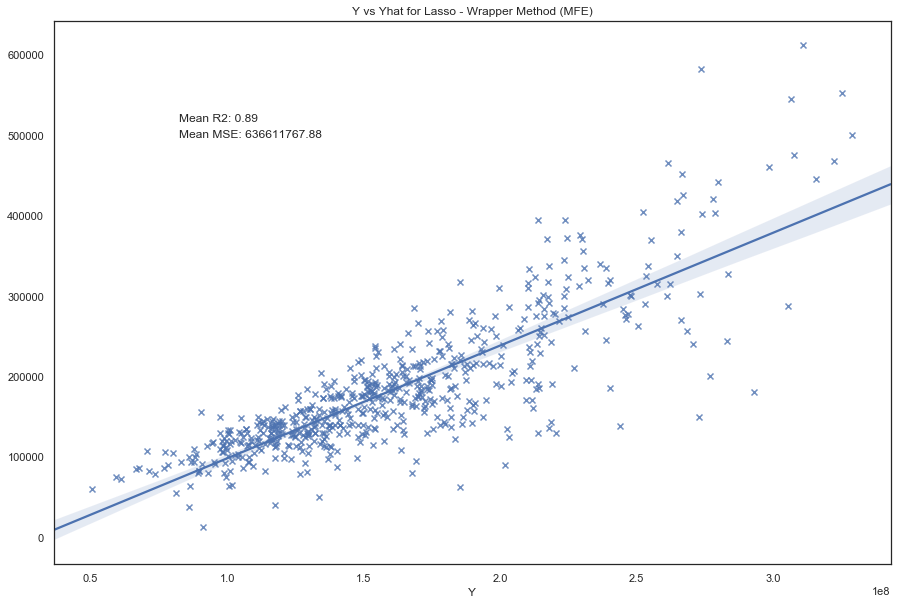

In [40]:
preds = lasso_plots(X_train_rs, y_train, X_test, y_test, rfe_list, "Wrapper Method (MFE)")

In [41]:
wrapper_lasso_r2 = preds[1]
wrapper_lasso_mse = preds[2]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

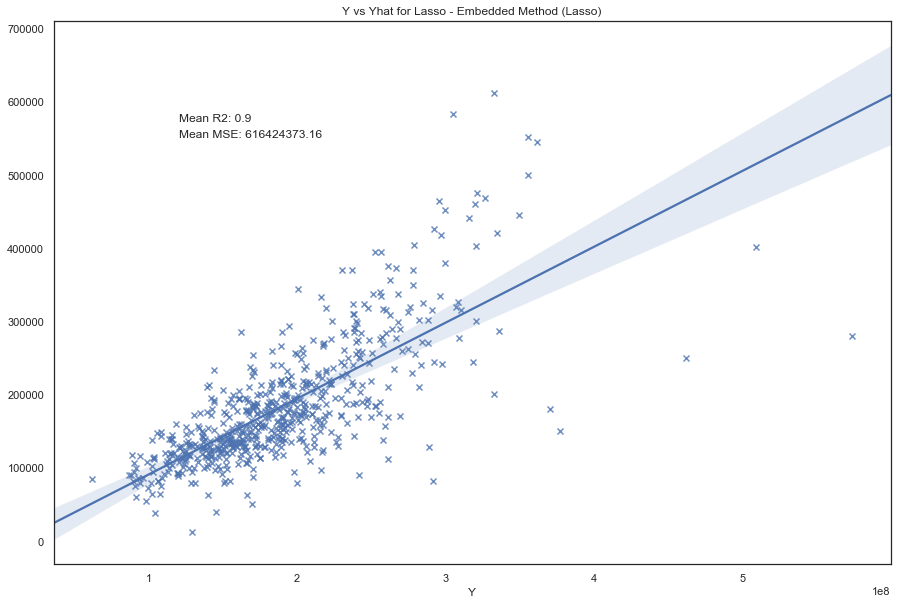

In [42]:
preds = lasso_plots(X_train_rs, y_train, X_test, y_test, lasso_list, "Embedded Method (Lasso)")

In [43]:
embedded_lasso_r2 = preds[1]
embedded_lasso_mse = preds[2]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

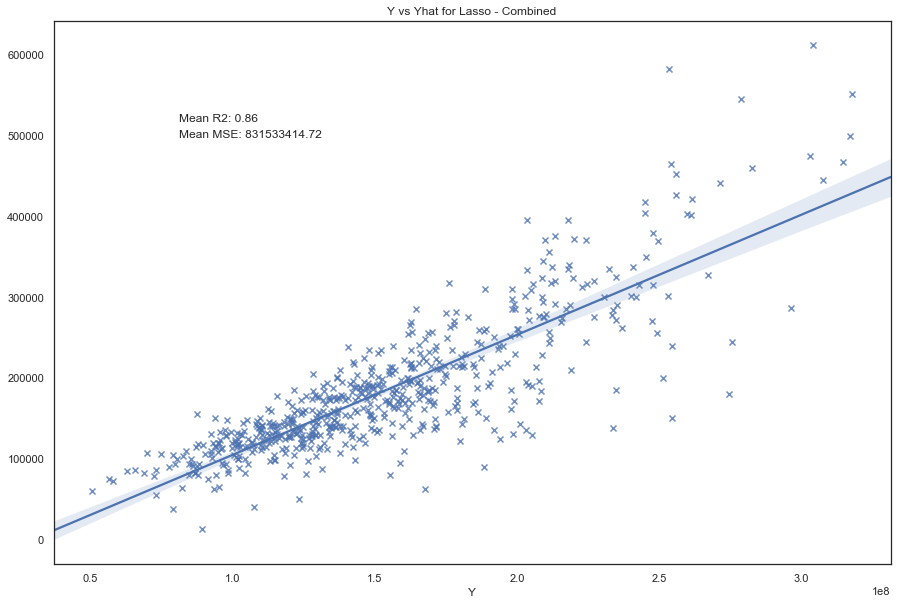

In [44]:
preds = lasso_plots(X_train_rs, y_train, X_test, y_test, combined_list, "Combined")

In [45]:
combined_lasso_r2 = preds[1]
combined_lasso_mse = preds[2]

### 5.2 ElasticNet

In [46]:
#Running this is painful, it will take awhile
#Also, this is bad code
def enet_plots(X, y, Xtest, ytest, features, title):
    sns.set(font_scale = 1)
    sns.set_style('white')

    #only takes in featurers that are present in the kaggle test set
    data = pd.DataFrame(data = X, columns = X_train.columns)[[n for n in Kag_full.columns if n in features]]
    Xtest = pd.DataFrame(data = Xtest, columns = X_test.columns)[[n for n in Kag_full.columns if n in features]]
    kag = pd.DataFrame(data = kag_rs, columns = Kag_full.columns)[[n for n in Kag_full.columns if n in features]]

    #find optimal alpha
    l1_ratios = np.linspace(0.01, 1.0, 25)

    optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10)
    optimal_enet.fit(data, y)
    enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)
    enet.fit(data, y)

    #score the model
    r2 = np.round(cross_val_score(enet, data, y, cv=kf, scoring = "r2").mean(), decimals = 2)
    mse = np.round(-cross_val_score(enet, data, y, cv=kf, scoring = "neg_mean_squared_error").mean(), decimals = 2)
    
    #predict for test set, and predict for kaggle set if we want to export to kaggle
    predictions = enet.predict(Xtest)
    predictions2 = enet.predict(kag)
    plt.figure(figsize=(15,10))
    ax1 = sns.regplot(predictions, ytest, marker="x")
    ax1.set_title("Y vs Yhat for ENet - {}".format(title))
    ax1.set_xlabel("Yhat") 
    ax1.set_xlabel("Y") 
    ax1.text(0.15, 0.83, "Mean R2: {}".format(r2), ha="left", va="top", transform=ax1.transAxes, fontsize=12)
    ax1.text(0.15, 0.8, "Mean MSE: {}".format(mse), ha="left", va="top", transform=ax1.transAxes, fontsize=12)
    return predictions2, r2, mse

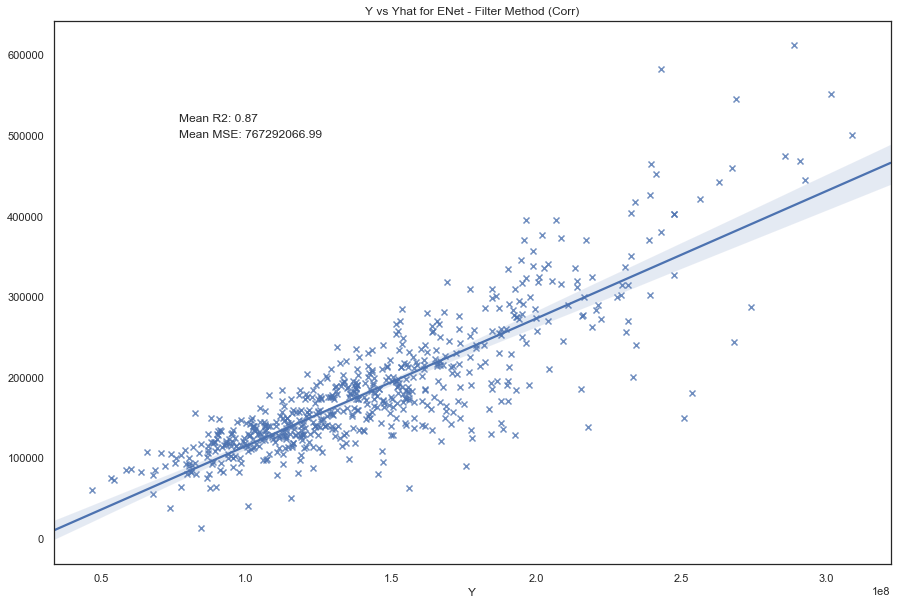

In [47]:
preds = enet_plots(X_train_rs, y_train, X_test, y_test, corr_list, "Filter Method (Corr)")

In [48]:
filter_enet_r2 = preds[1]
filter_enet_mse = preds[2]

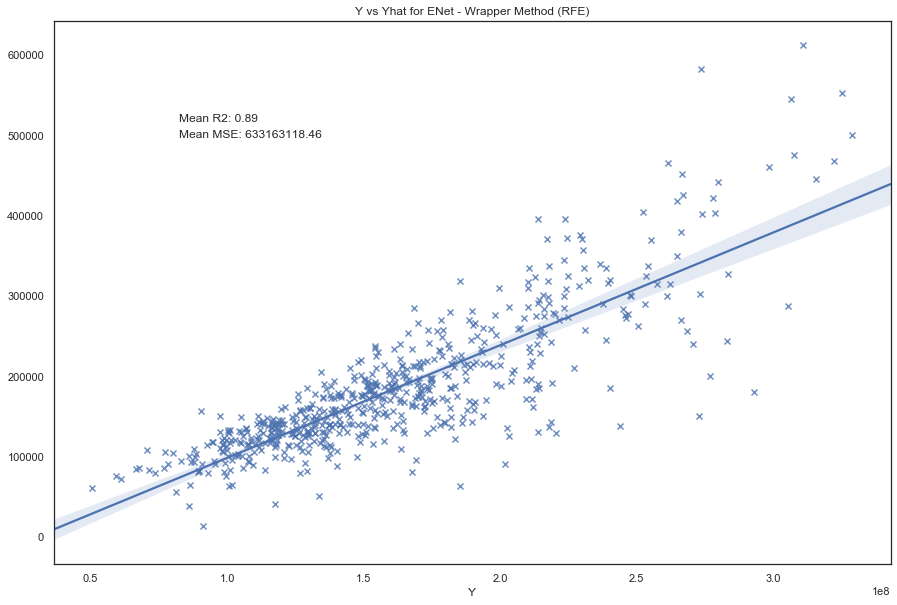

In [49]:
preds = enet_plots(X_train_rs, y_train, X_test, y_test, rfe_list, "Wrapper Method (RFE)")

In [50]:
wrapper_enet_r2 = preds[1]
wrapper_enet_mse = preds[2]

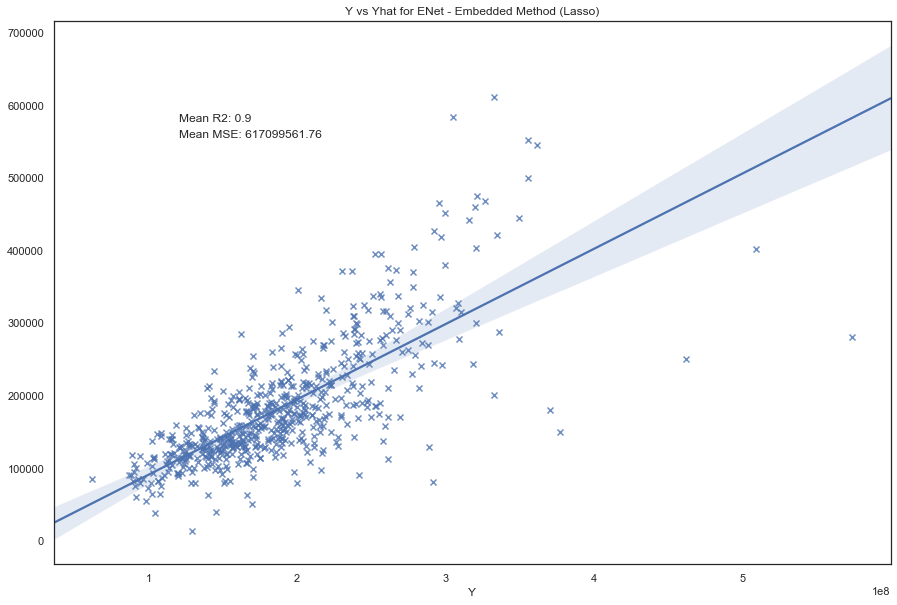

In [51]:
preds = enet_plots(X_train_rs, y_train, X_test, y_test, lasso_list, "Embedded Method (Lasso)")

In [52]:
embedded_enet_r2 = preds[1]
embedded_enet_mse = preds[2]

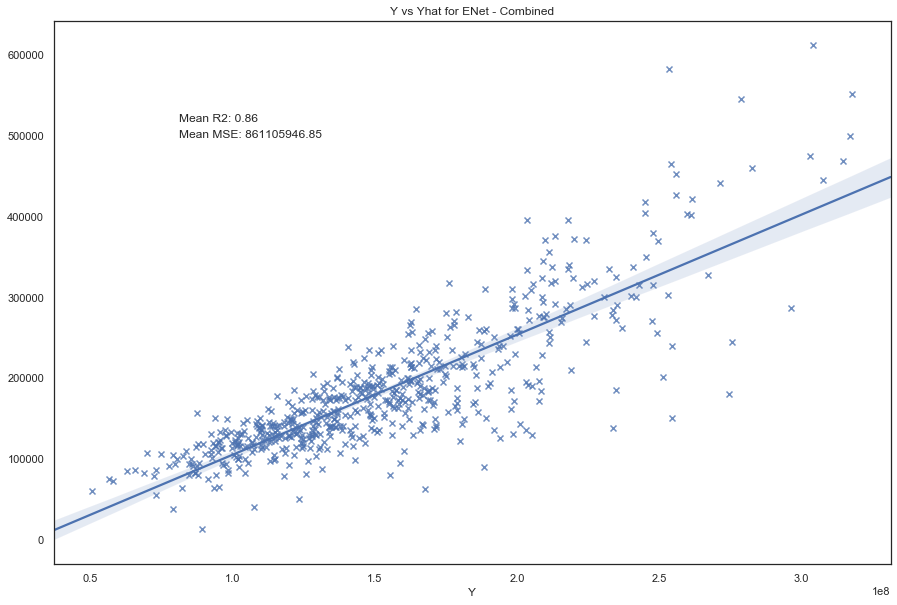

In [53]:
preds = enet_plots(X_train_rs, y_train, X_test, y_test, combined_list, "Combined")

In [54]:
combined_enet_r2 = preds[1]
combined_enet_mse = preds[2]

It is interesting to note that the 10 features obtained from the intersection explained previously hold most of the predictive power. We will go further by using polynomial features to account for interaction effects and try to improve our model.

### 5.2 Polynomial ElasticNet

ElasticNet has been yielding some good results, so I will try to improve on them by testing polynomial features on the combined list, since it only has 10 features, and the lasso list, since it yielded the best R2 and MSE.

In [55]:
#Running this is painful, it will take awhile
#Also, this is bad code
def enet_polyplots(X, y, Xtest, ytest, features, title):
    sns.set(font_scale = 1)
    sns.set_style('white')

    #only takes in featurers that are present in the kaggle test set
    data = pd.DataFrame(data = X, columns = X_train.columns)[[n for n in Kag_full.columns if n in features]]
    Xtest = pd.DataFrame(data = Xtest, columns = X_test.columns)[[n for n in Kag_full.columns if n in features]]
    kag = pd.DataFrame(data = kag_rs, columns = Kag_full.columns)[[n for n in Kag_full.columns if n in features]]
    
    #do polynomial things
    poly = PolynomialFeatures(2, include_bias = True)
    data_poly = poly.fit_transform(data)
    Xtest_poly = poly.fit_transform(Xtest)
    kag_poly = poly.fit_transform(kag)
    
    #find optimal alpha
    l1_ratios = np.linspace(0.01, 1.0, 25)

    optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10)
    optimal_enet.fit(data_poly, y)
    enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)
    enet.fit(data_poly, y)

    #score the model
    r2 = np.round(cross_val_score(enet, data_poly, y, cv=kf, scoring = "r2").mean(), decimals = 2)
    mse = np.round(-cross_val_score(enet, data_poly, y, cv=kf, scoring = "neg_mean_squared_error").mean(), decimals = 2)
    
    #predict for test set, and predict for kaggle set if we want to export to kaggle
    predictions = enet.predict(data_poly)
    predictions2 = enet.predict(kag_poly)
    plt.figure(figsize=(15,10))
    ax1 = sns.regplot(predictions, y, marker="x")
    ax1.set_title("Y vs Yhat for ENet - {}".format(title))
    ax1.set_xlabel("Yhat") 
    ax1.set_xlabel("Y") 
    ax1.text(0.15, 0.83, "Mean R2: {}".format(r2), ha="left", va="top", transform=ax1.transAxes, fontsize=12)
    ax1.text(0.15, 0.8, "Mean MSE: {}".format(mse), ha="left", va="top", transform=ax1.transAxes, fontsize=12)
    return predictions2, r2, mse

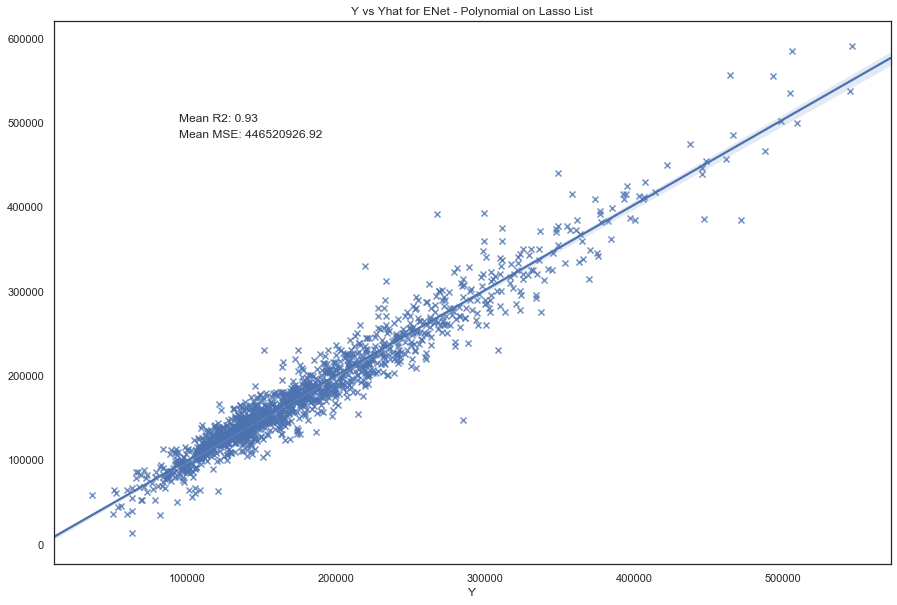

In [86]:
preds = enet_polyplots(X_train_rs, y_train, X_test, y_test, lasso_list, "Polynomial on Lasso List")

In [87]:
embedded_polyenet_r2 = preds[1]
embedded_polyenet_mse = preds[2]

In [ ]:
#poop out a kaggle submission
df_kaggle = pd.DataFrame({"SalePrice" : preds[0]}, index = Kag_full["id"])
df_kaggle.to_csv("df_kaggle_poly_enet_final1.csv")

>This yielded a good kaggle score of 26286.63922, but uses more than 25 features after taking into account the polynomials.
Let's try this with the combined list, which only has 10 features.

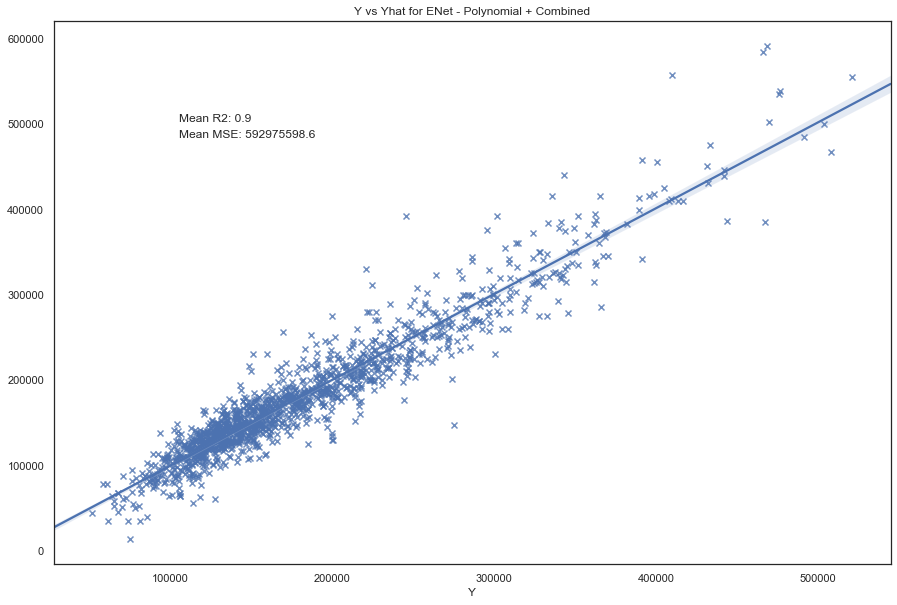

In [58]:
preds = enet_polyplots(X_train_rs, y_train, X_test, y_test, combined_list, "Polynomial + Combined")

In [59]:
combined_polyenet_r2 = preds[1]
combined_polyenet_mse = preds[2]

In [88]:
#poop out a kaggle submission
df_kaggle = pd.DataFrame({"SalePrice" : preds[0]}, index = Kag_full["id"])
df_kaggle.to_csv("df_kaggle_poly_enet_final2.csv")

> The combined list performed as well as the lasso list, with a kaggle score of 27,000 despite a much shorter list of features. 15 fewer features, but only slighly poorer performance in predictive power.

### 5.3 Summary of Models

In [61]:
r2filter_column = [filter_ridge_r2, filter_lasso_r2, filter_enet_r2, "-"]
r2embedded_column = [embedded_ridge_r2, embedded_lasso_r2, embedded_enet_r2, embedded_polyenet_r2]
r2wrapper_column = [wrapper_ridge_r2, wrapper_lasso_r2, wrapper_enet_r2, "-"]
r2combined_column = [combined_ridge_r2, combined_lasso_r2, combined_enet_r2, combined_polyenet_r2]

In [62]:
msefilter_column = [filter_ridge_mse, filter_lasso_mse, filter_enet_mse, "-"]
mseembedded_column = [embedded_ridge_mse, embedded_lasso_mse, embedded_enet_mse, embedded_polyenet_mse]
msewrapper_column = [wrapper_ridge_mse, wrapper_lasso_mse, wrapper_enet_mse, "-"]
msecombined_column = [combined_ridge_mse, combined_lasso_mse, combined_enet_mse, combined_polyenet_mse]

In [63]:
pd.DataFrame({"Filter": r2filter_column,
             "Embedded": r2embedded_column,
             "Wrapper": r2wrapper_column,
             "Combined": r2combined_column},
            index = ["Ridge", "Lasso", "Enet", "Poly Enet"])

Filter  Embedded Wrapper  Combined
Ridge       0.87      0.89    0.89      0.86
Lasso       0.87      0.90    0.89      0.86
Enet        0.87      0.90    0.89      0.86
Poly Enet      -      0.93       -      0.90

In [64]:
pd.DataFrame({"Filter": msefilter_column,
             "Embedded": mseembedded_column,
             "Wrapper": msewrapper_column,
             "Combined": msecombined_column},
            index = ["Ridge", "Lasso", "Enet", "Poly Enet"])

Filter      Embedded      Wrapper      Combined
Ridge      7.65264e+08  6.121902e+08  6.43408e+08  8.357110e+08
Lasso      7.62479e+08  6.164244e+08  6.36612e+08  8.315334e+08
Enet       7.67292e+08  6.170996e+08  6.33163e+08  8.611059e+08
Poly Enet            -  6.694659e+08            -  5.929756e+08

The dataframes above summarize the performances of my various models. The best performing model is the Poly Enet.
In the next section, we will investigate the features of this model.

## 6. Analysis of Best Model

In [65]:
#Repeating the same code as the function, while tweaking some values
X = X_train_rs
y = y_train
Xtest = X_test
ytest = y_test
features = combined_list
title = "Combined"

#only takes in featurers that are present in the kaggle test set
data = pd.DataFrame(data = X, columns = X_train.columns)[[n for n in Kag_full.columns if n in features]]
Xtest = pd.DataFrame(data = Xtest, columns = X_test.columns)[[n for n in Kag_full.columns if n in features]]
kag = pd.DataFrame(data = kag_rs, columns = Kag_full.columns)[[n for n in Kag_full.columns if n in features]]
    
#do polynomial things
poly = PolynomialFeatures(2, include_bias = True)
data_poly = poly.fit_transform(data)
Xtest_poly = poly.fit_transform(Xtest)
kag_poly = poly.fit_transform(kag)
    
#find optimal alpha
l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10)
optimal_enet.fit(data_poly, y)
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)
enet.fit(data_poly, y)

ElasticNet(alpha=46.0022593894042, copy_X=True, fit_intercept=True,
           l1_ratio=1.0, max_iter=1000, normalize=False, positive=False,
           precompute=False, random_state=None, selection='cyclic', tol=0.0001,
           warm_start=False)

In [66]:
feature_names = [n.replace("_", " ").title() for n in poly.get_feature_names(data.columns)]
enet_coeffs = pd.DataFrame({"coeff" : enet.coef_}, index = feature_names)
enet_coeffs = enet_coeffs.loc[(enet_coeffs!=0).any(axis=1)].sort_values(by = "coeff", ascending = False)
enet_coeffs

coeff
Gr Liv Area                         59490.542921
Overall Qual                        39241.506656
Remodel Age^2                       30749.203039
Total Bsmt Sf                       26401.578455
Bsmtfin Sf 1                        20705.792069
Overall Qual Gr Liv Area            16265.294932
Total Bsmt Sf Gr Liv Area           15249.493864
Exter Qual Gr Liv Area              15119.896151
Bsmtfin Sf 1 Total Bsmt Sf          14757.737959
Garage Area                         12988.413628
Overall Qual 1St Flr Sf             11344.472394
Exter Qual Garage Area              10504.392125
Exter Qual 1St Flr Sf                9298.791913
Gr Liv Area Garage Area              8039.483509
Exter Qual                           5446.771743
Bldg Age Remodel Age                 3908.227573
Total Bsmt Sf^2                      3781.668718
Exter Qual Bldg Age                  3479.606145
Total Bsmt Sf Garage Area            3384.464789
Gr Liv Area Neighborhood Nridght     3305.486448
Overall Qual Total Bsmt Sf           3167.741409
Overall Qual Garage Area             2674.463519
Gr Liv Area^2                        2413.774910
Overall Qual Remodel Age             2369.454608
Exter Qual^2                         2114.748977
Overall Qual Bsmtfin Sf 1            1951.842717
1St Flr Sf                           1777.288169
Total Bsmt Sf Neighborhood Nridght   1632.917357
Overall Qual^2                       1299.665491
Total Bsmt Sf Remodel Age              -4.505361
Exter Qual Neighborhood Nridght      -125.221148
1St Flr Sf^2                        -1701.041354
Bldg Age                            -1816.951128
Garage Area^2                       -7561.529629
Bsmtfin Sf 1 Remodel Age            -7831.767178
Bsmtfin Sf 1 Gr Liv Area           -10666.531409
Gr Liv Area Remodel Age            -20080.518918
Total Bsmt Sf 1St Flr Sf           -21377.359102
Bldg Age^2                         -30090.690551
Remodel Age                        -43143.788806

Text(0, 0.5, 'Coefficient')

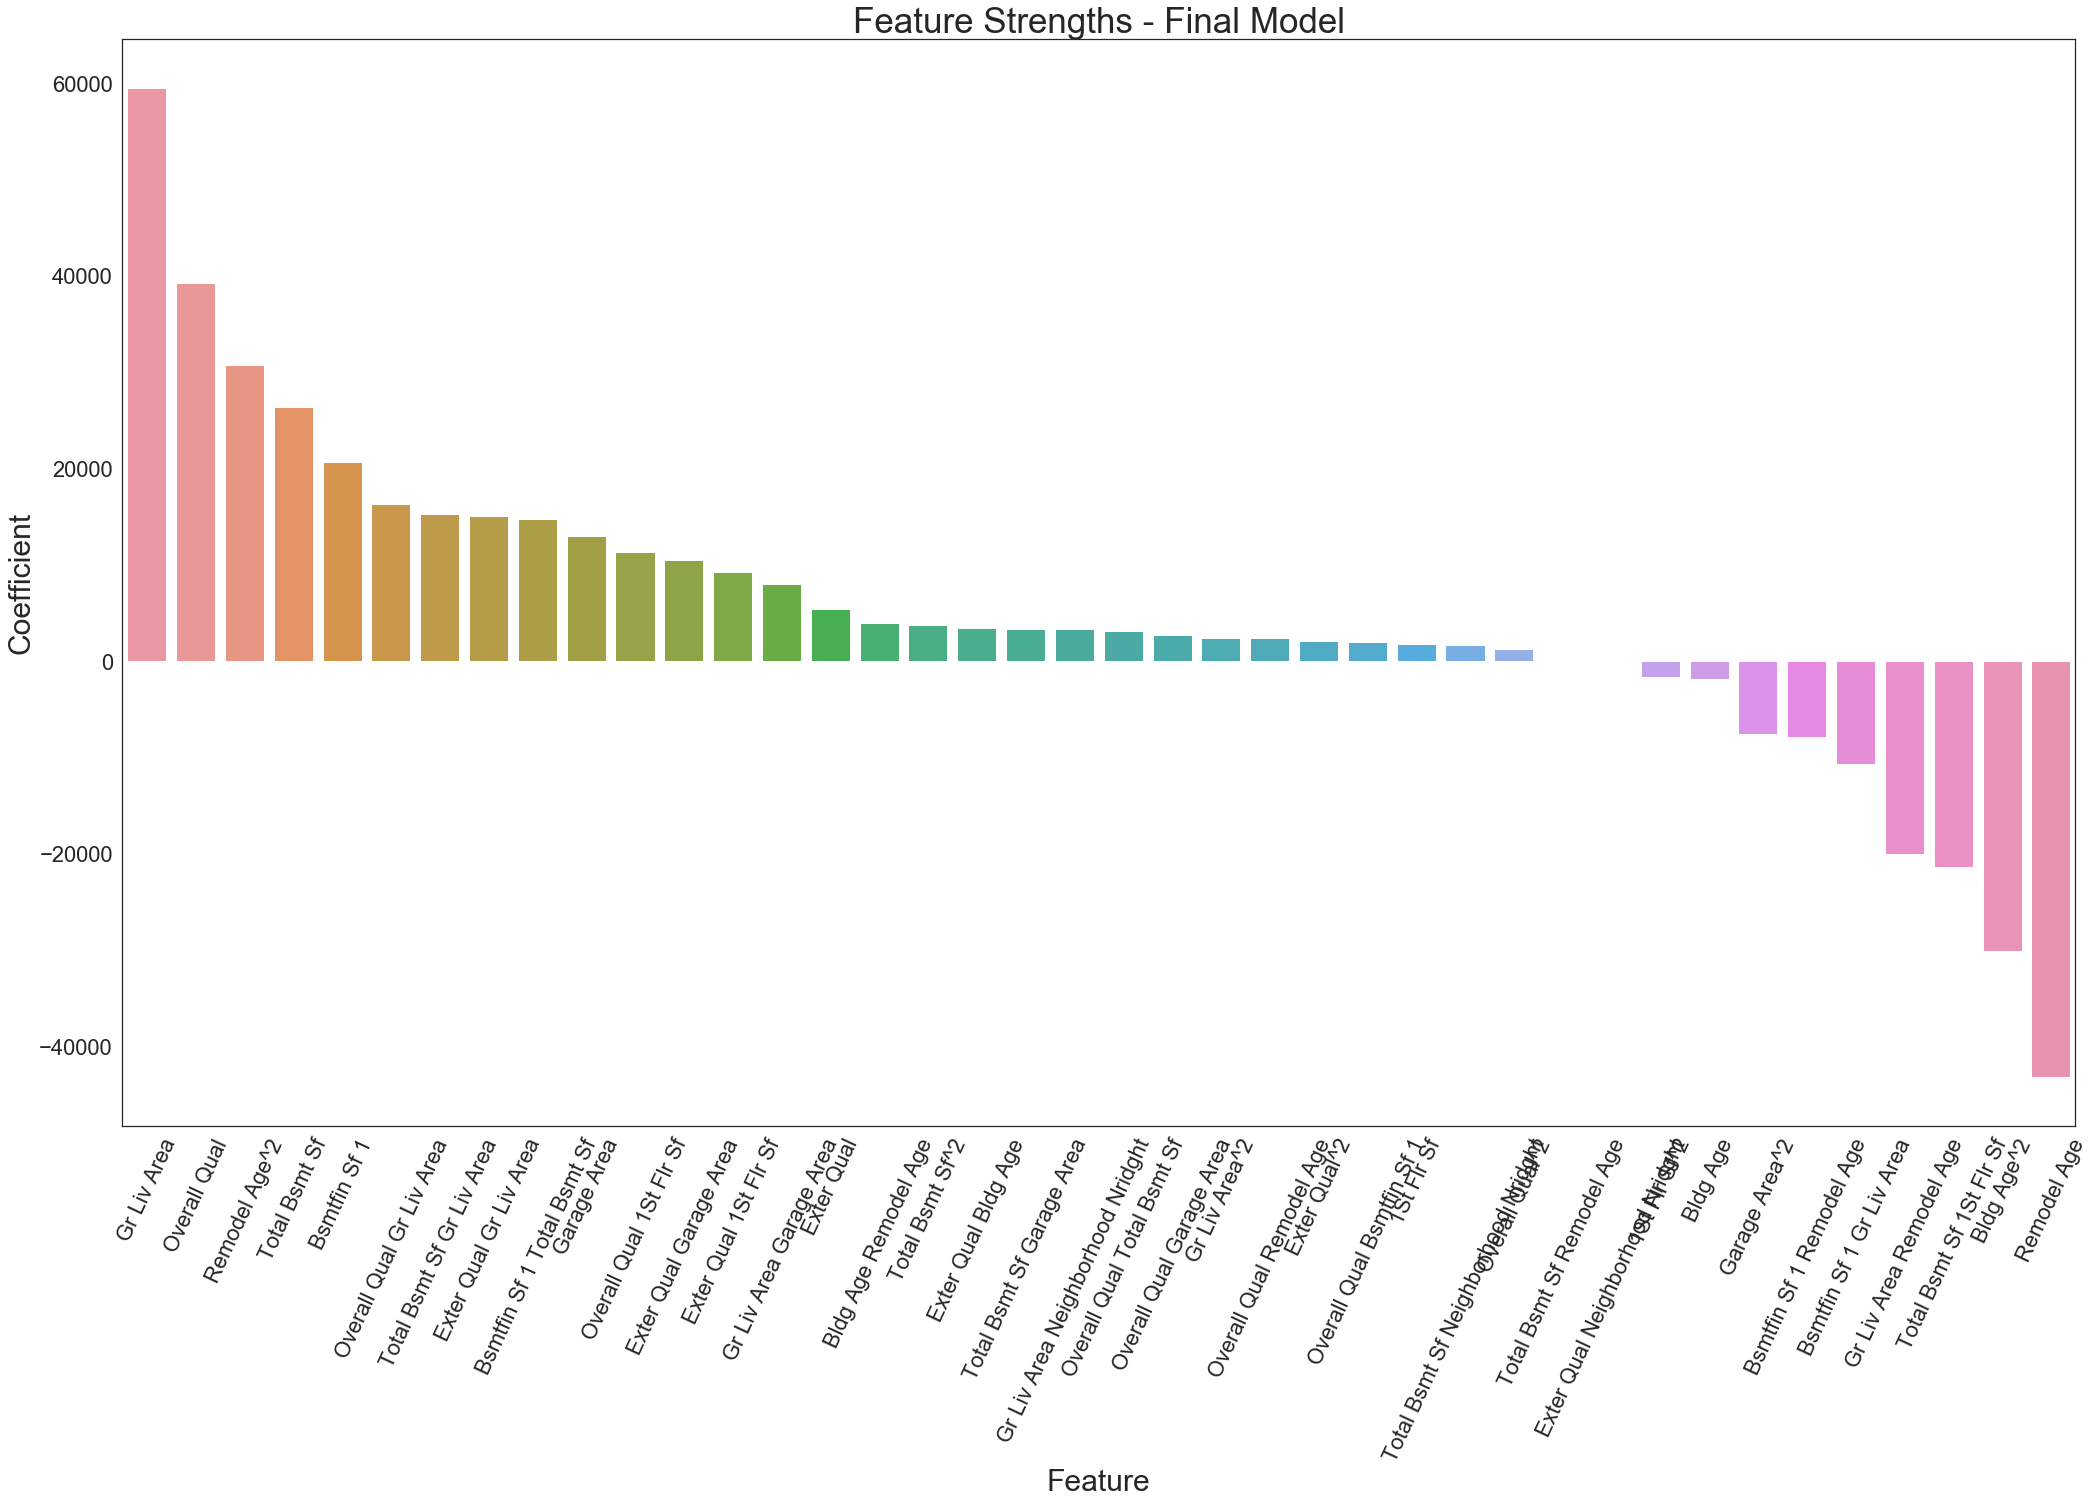

In [67]:
plt.figure(figsize = (35,20))
sns.set(font_scale = 2, style="white")
ax = sns.barplot(x = enet_coeffs.index, y = enet_coeffs["coeff"], data = enet_coeffs)
plt.setp(ax.get_xticklabels(), rotation=65)
ax.set_title("Feature Strengths - Final Model", fontsize = 35)
ax.set_xlabel("Feature", fontsize = 30)
ax.set_ylabel("Coefficient", fontsize = 30)


Exactly 25 features!
Some strange findings though...

    1) Houses in the Northridge Heights neighborhood with a large garage sell for $6818 more for every extra squarefoot 
    of garage?
    
    2) Above grade (ground) living area square feet is the strongest coefficient, followed by overall quality.
    
    3) Building age is strongly negatively correlated - your house loses $20,000 in value every year.
    
Caveat - there are some differences in the final output whenever I rerun the model, since I did not set a random seed. I did not set a random seed so I could rerun the whole notebook from the test train split, and see if my results differed. I found, interestingly, that the polynomials/interactionvariables changed slightly with each run, but the main findings remain the same.


In [ ]:
plt.figure(figsize = (25,25))

corr = pd.DataFrame(data=data_poly, columns = feature_names).drop("1", axis = 1).corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, vmax=.3, square=True, annot=True, cmap="coolwarm").set_title(title, fontsize=20)

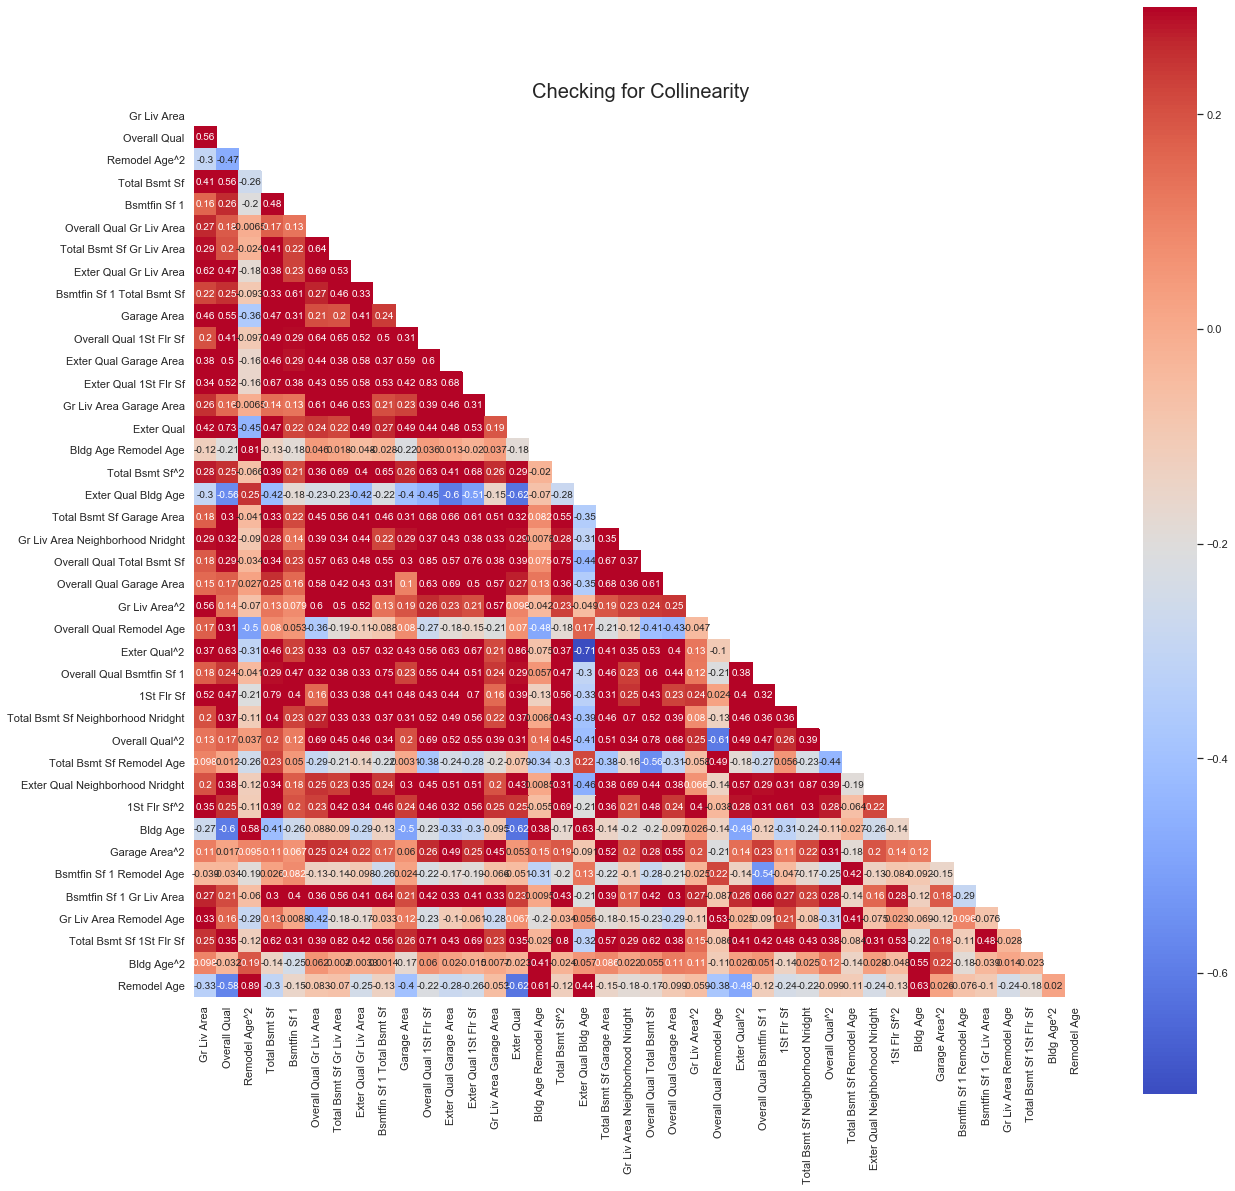

In [100]:
#Plot heatmap for final features
slow_heat(pd.DataFrame(data_poly, columns = feature_names), enet_coeffs.index, "Checking for Collinearity")

Some collinearity still exists, but it isn't as significant as before. We can improve on this in future iterations by dropping the heavily correlated features. But for now, I'll settle with this model.

# 7. Conclusion

There are three main findings:

    1) For feature selection, the intersection between the three feature selection methods yielded the features with the 
       highest predictive power.
       
    2) Polynomials were needed to factor in correlations between the independent variables, and this led to a problem of 
       over dimensionality. Using a smaller list yielded as much predictive power as using 25! features.
    
    3) The ElasticNet model was the best performing in terms of both R2 and MSE.

# XGBoost (out of scope)

In [68]:
import xgboost as xgb

In [101]:
#Bad code alert - created new dataframes in case i mess up my originals
Xgb_train = X_train[[col for col in X_train.columns if col in Kag_full.columns]]
ygb_train = y_train
Xgb_test = X_test[[col for col in X_train.columns if col in Kag_full.columns]]
Xgb_kag = Kag_full[[col for col in Kag_full.columns if col in Xgb_train.columns]]

rs = RobustScaler(quantile_range=(10,90))
Xgb_train_rs = rs.fit_transform(Xgb_train)
Xgb_test_rs = rs.transform(Xgb_test)
Xgb_kag = rs.fit_transform(Xgb_kag)

#Warning - Computer explodes if you polynomial 200 features
#poly = PolynomialFeatures(2, include_bias = True)
#Xgb_train_rs_poly = poly.fit_transform(Xgb_train_rs)
#Xgb_test_rs_poly = poly.fit_transform(Xgb_test_rs)
#Xgb_kag_poly = poly.fit_transform(Xgb_kag)

data_dmatrix_train = xgb.DMatrix(data = Xgb_train_rs, label = ygb_train)
data_dmatrix_test = xgb.DMatrix(data = Xgb_test_rs, label = ygb_train)
data_dmatrix_kag = xgb.DMatrix(data= Xgb_kag)

In [71]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}
cv_results = xgb.cv(dtrain=data_dmatrix_train, params=params, nfold=3,
                    num_boost_round=90,early_stopping_rounds=10,metrics="rmse", as_pandas=True)


In [72]:
boost = xgb.train(params, data_dmatrix_train, 1000)
preds = boost.predict(data_dmatrix_test)
preds_kag = boost.predict(data_dmatrix_kag)

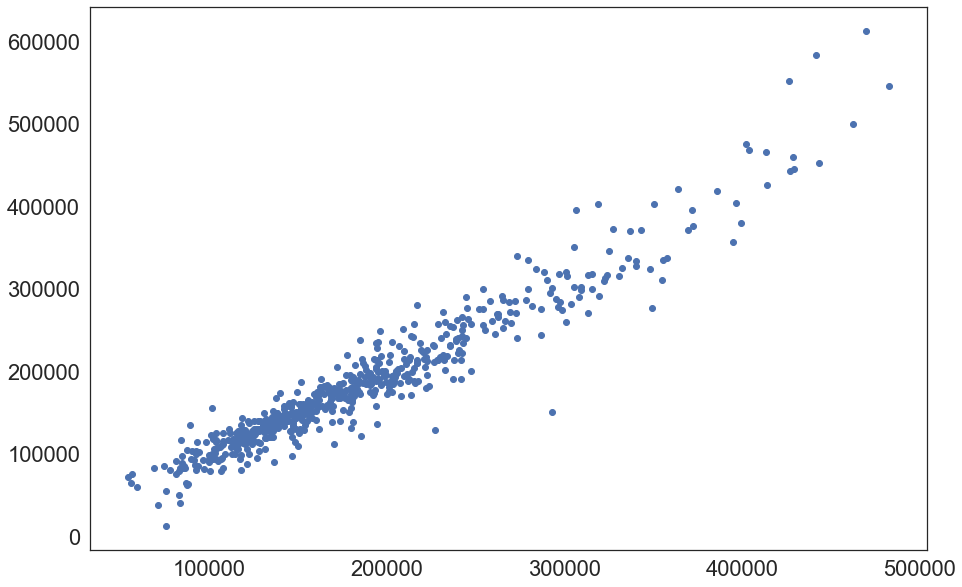

In [73]:
plt.figure(figsize = (15,10))
plt.scatter(preds, y_test)

<Figure size 1440x5040 with 0 Axes>

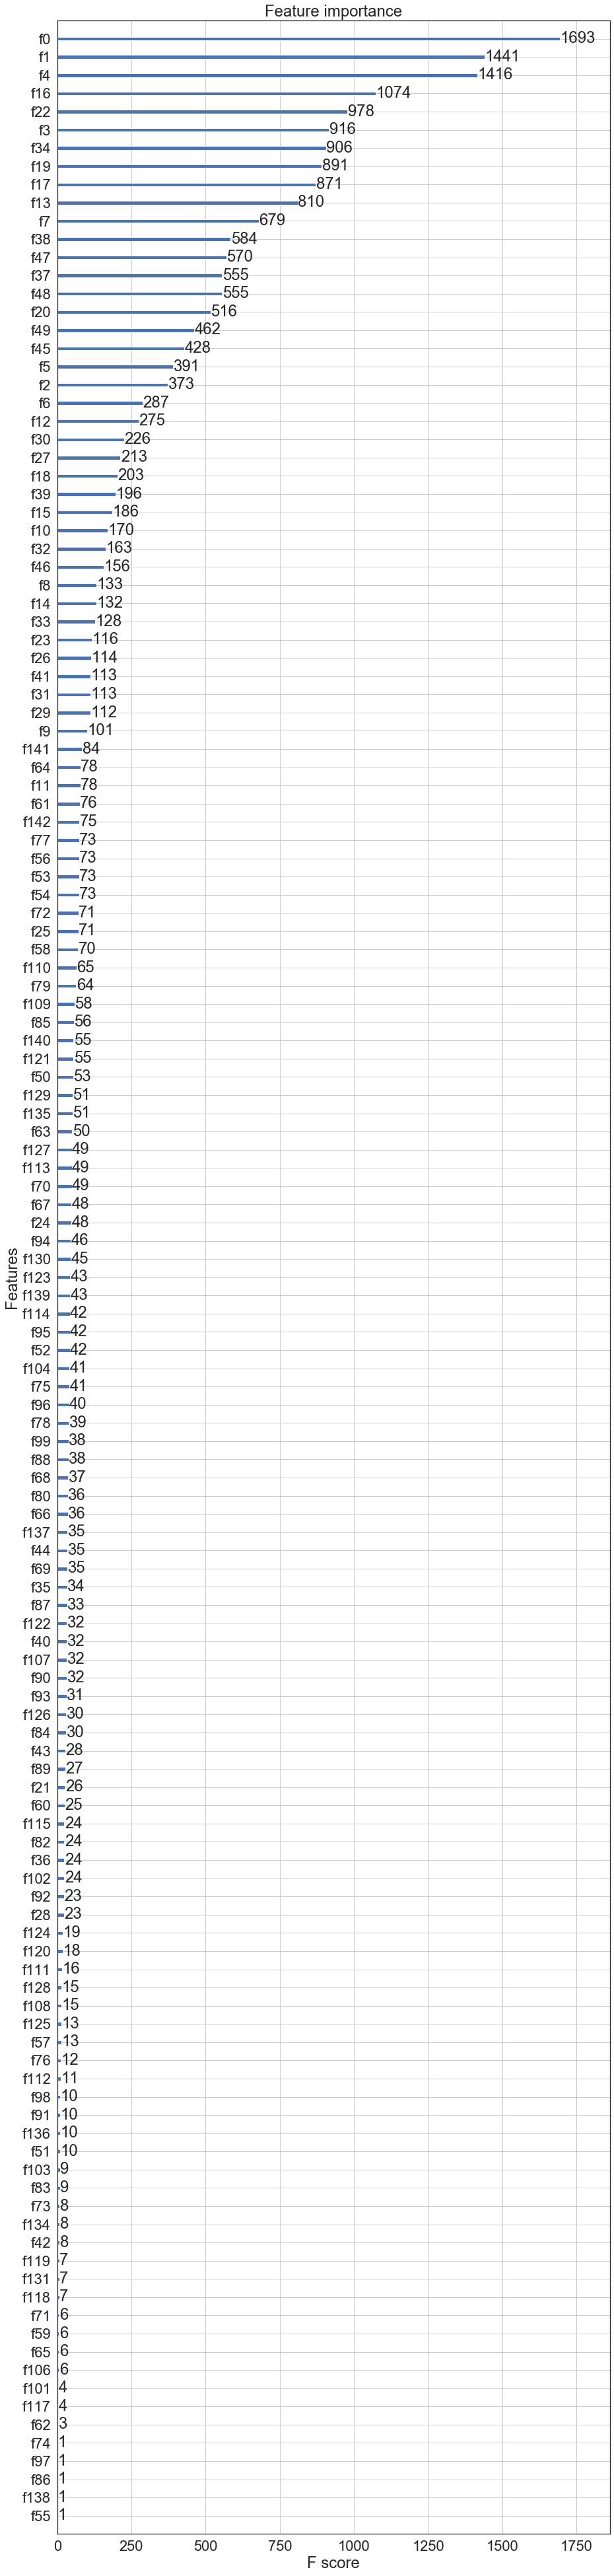

In [76]:
plt.figure(figsize=(20,70))
xgb.plot_importance(boost)
plt.show()

In [75]:
df_kaggle = pd.DataFrame({"SalePrice" : preds_kag}, index = Kag_full["id"])
df_kaggle.to_csv("df_kaggle_xgb.csv")

> XGB Private Score = 28.6k, Public Score = 31.6k

> Ehhhh, was expecting better considering the hype. Probably did something wrong. This is also probably grossly overfitted since all 200+ features were used.